In [1]:
import requests
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from pprint import pprint
from pathlib import Path
from statistics import mean
from requests.auth import HTTPBasicAuth
from client import client_id, client_secret

In [2]:
# Root directory to Top Country CSV folder
rootdir = Path('Top Country CSV')

# Loops through each csv file in Top Country CSV folder
file_list = [f for f in rootdir.glob("*.csv") if f.is_file()]

country = [str(file).split("\\")[-1].split("_")[0] for file in file_list]

In [3]:
## Authorization token to access spotify api (Required for all endpoints)
token_url = "https://accounts.spotify.com/api/token"
headers = {'content-type': 'application/x-www-form-urlencoded'}

token_params = {"grant_type" : "client_credentials"}

token_json = requests.post(token_url, params = token_params, headers = headers, auth = (client_id, client_secret)).json()
token = token_json['access_token']

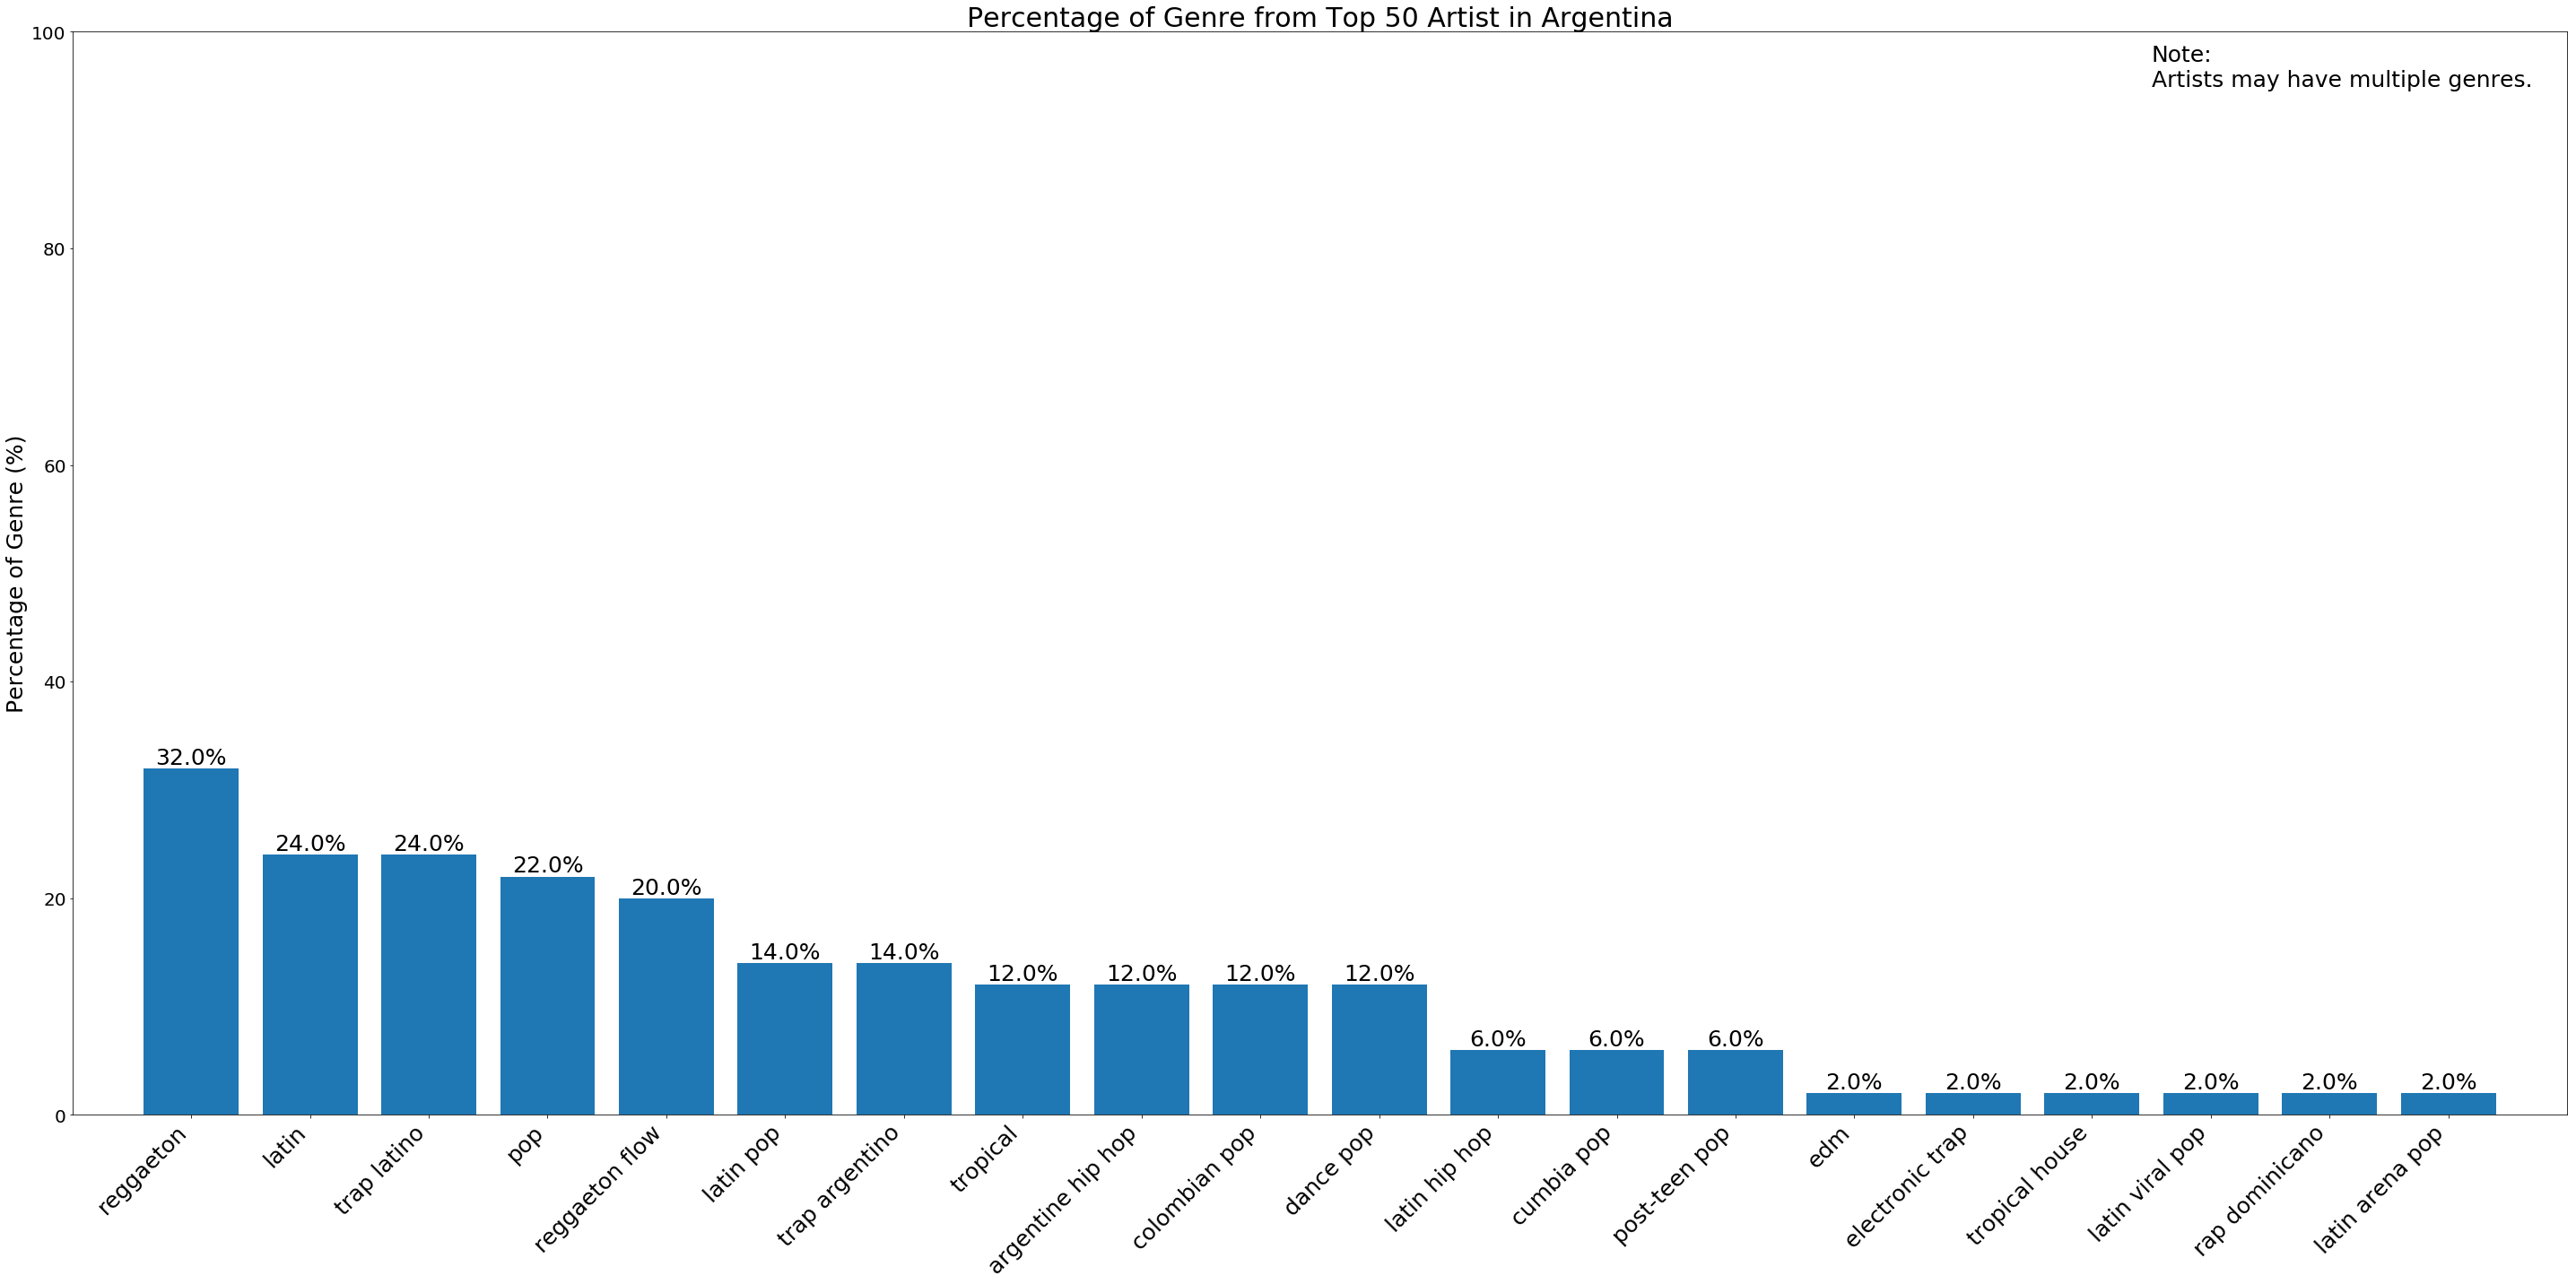

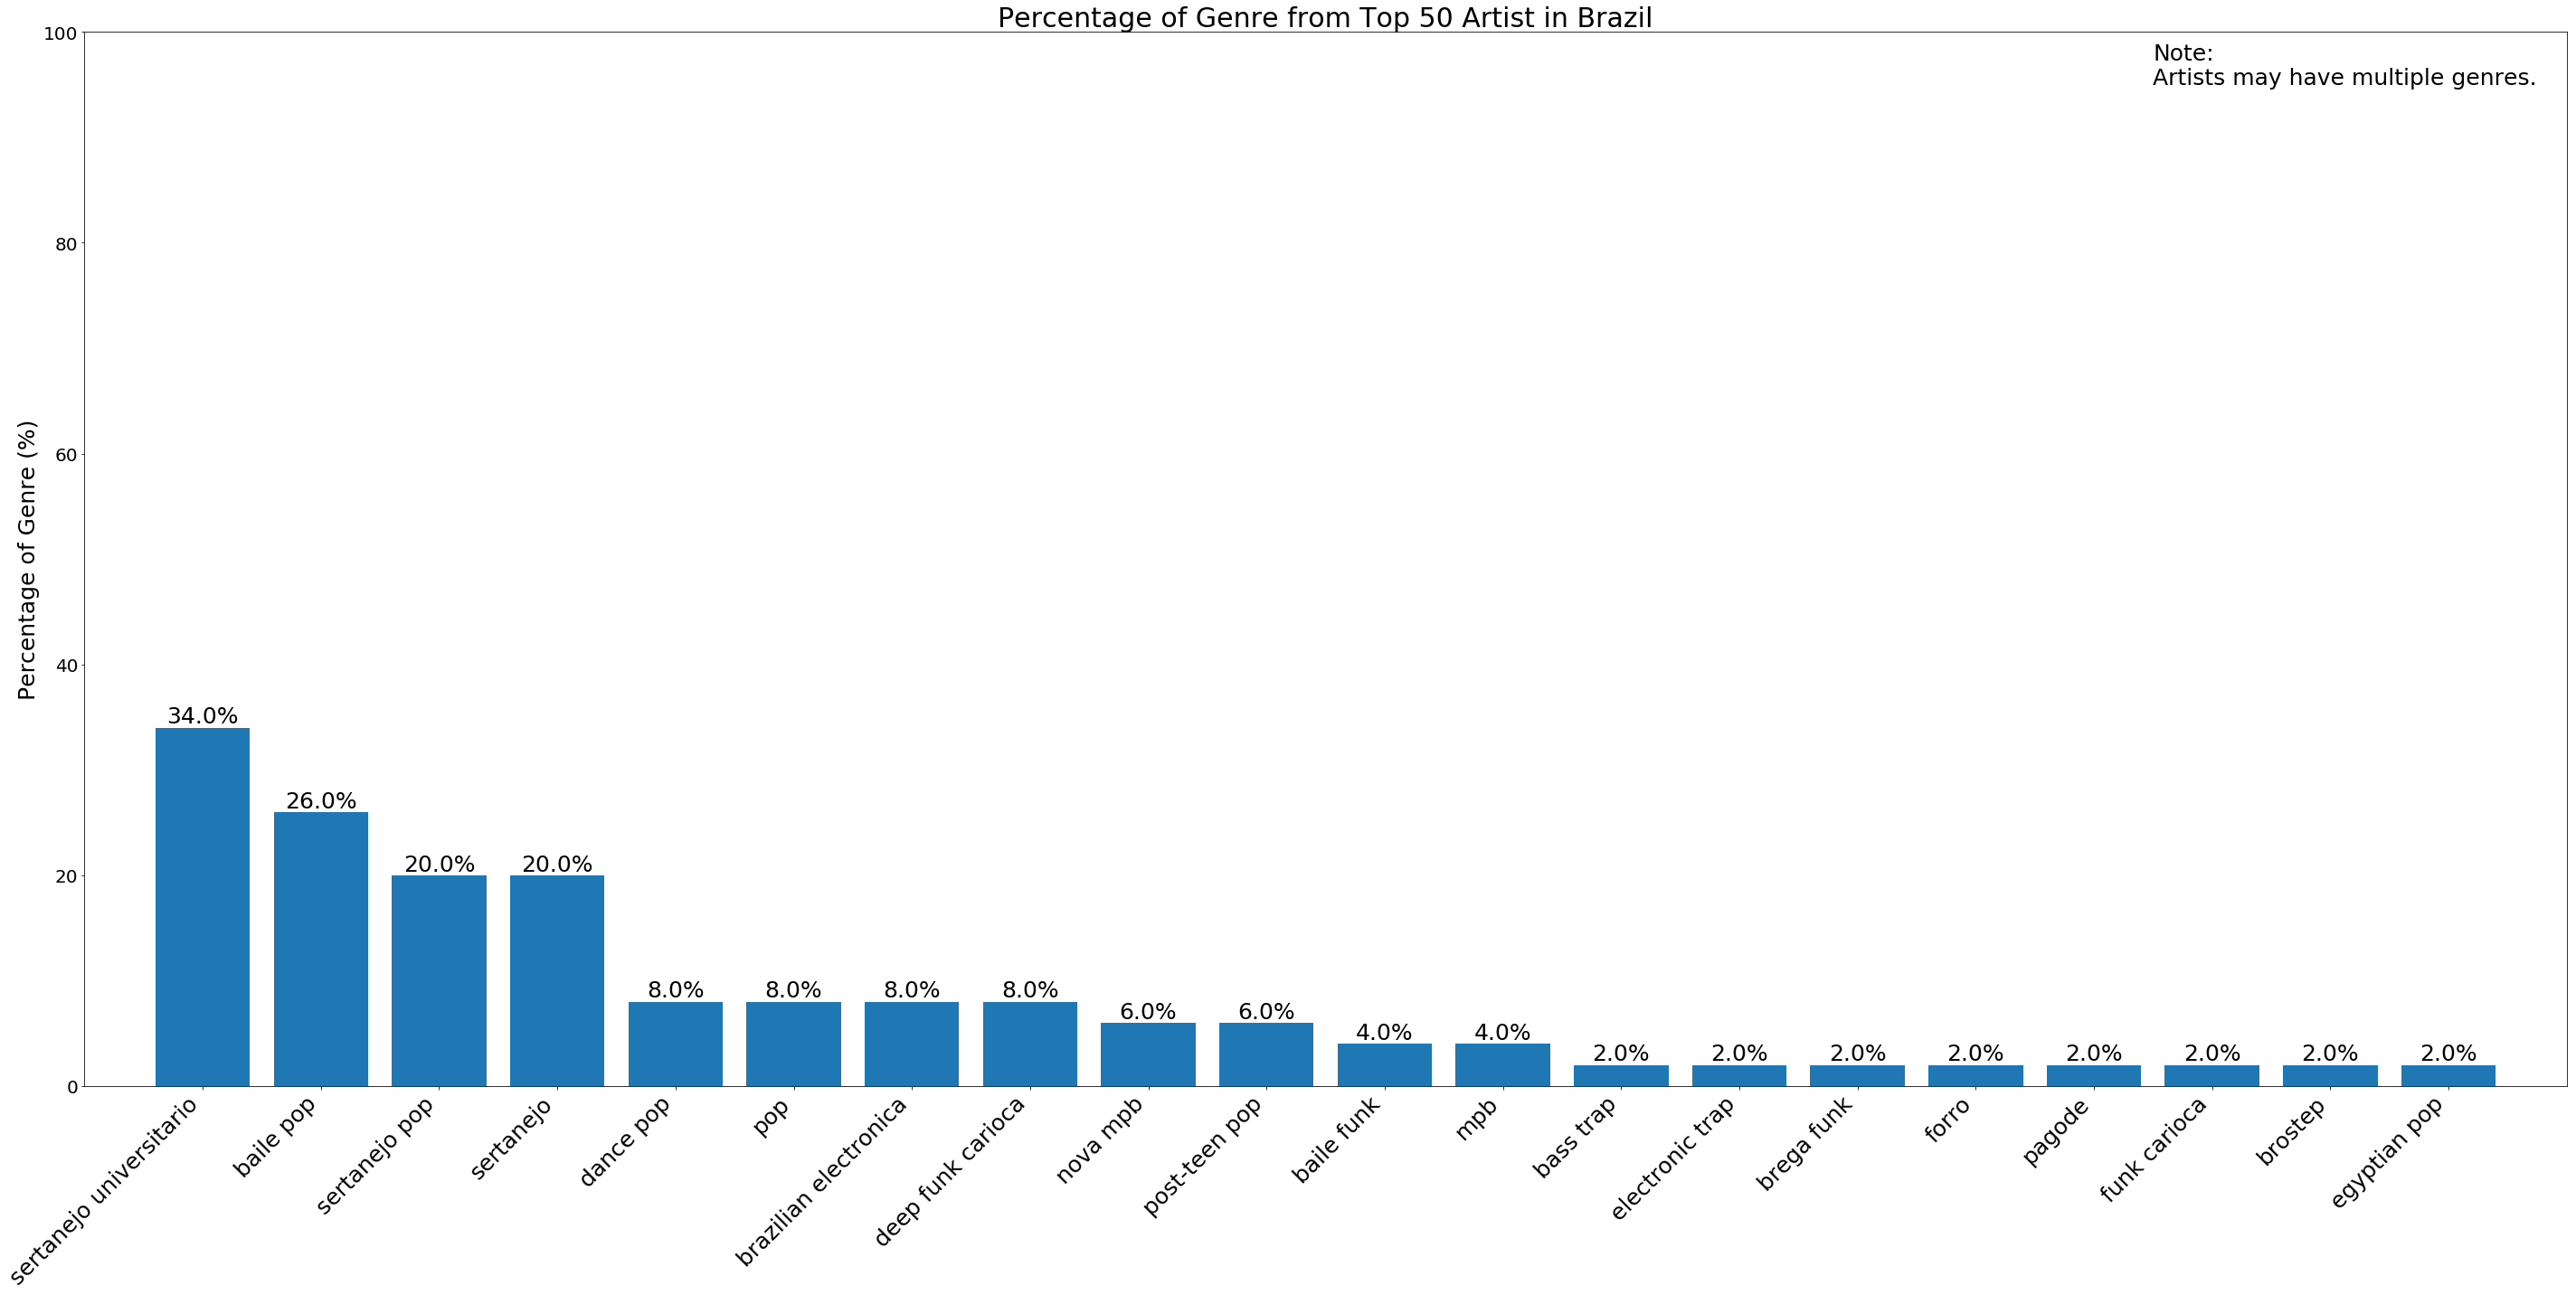

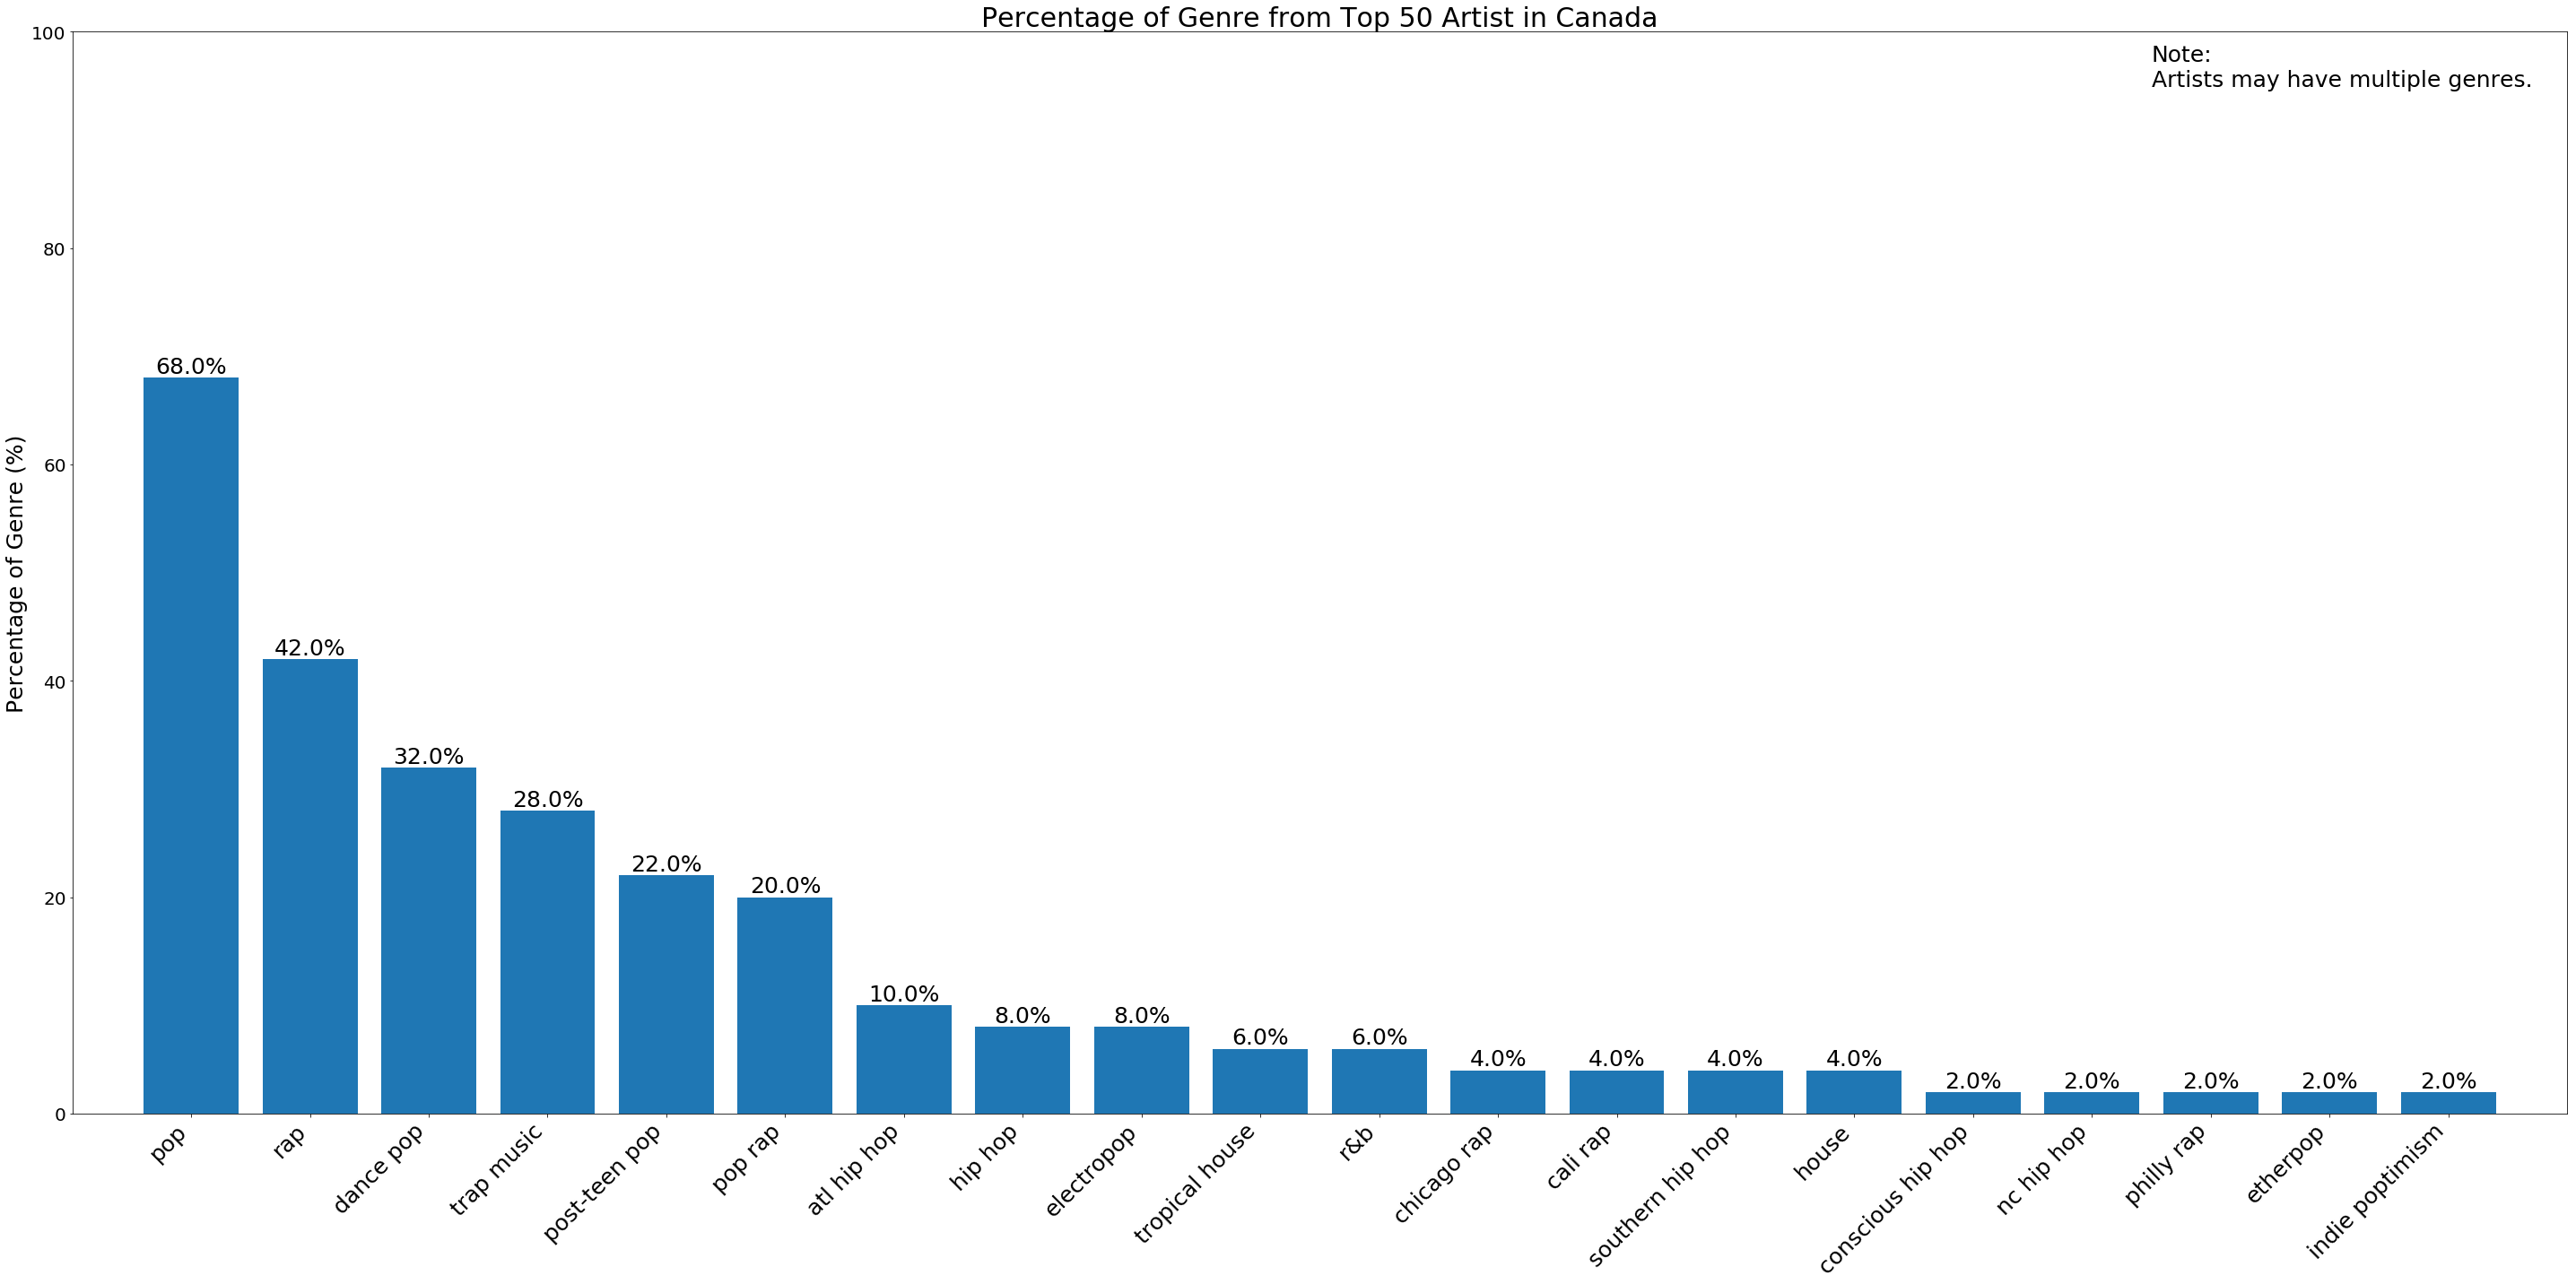

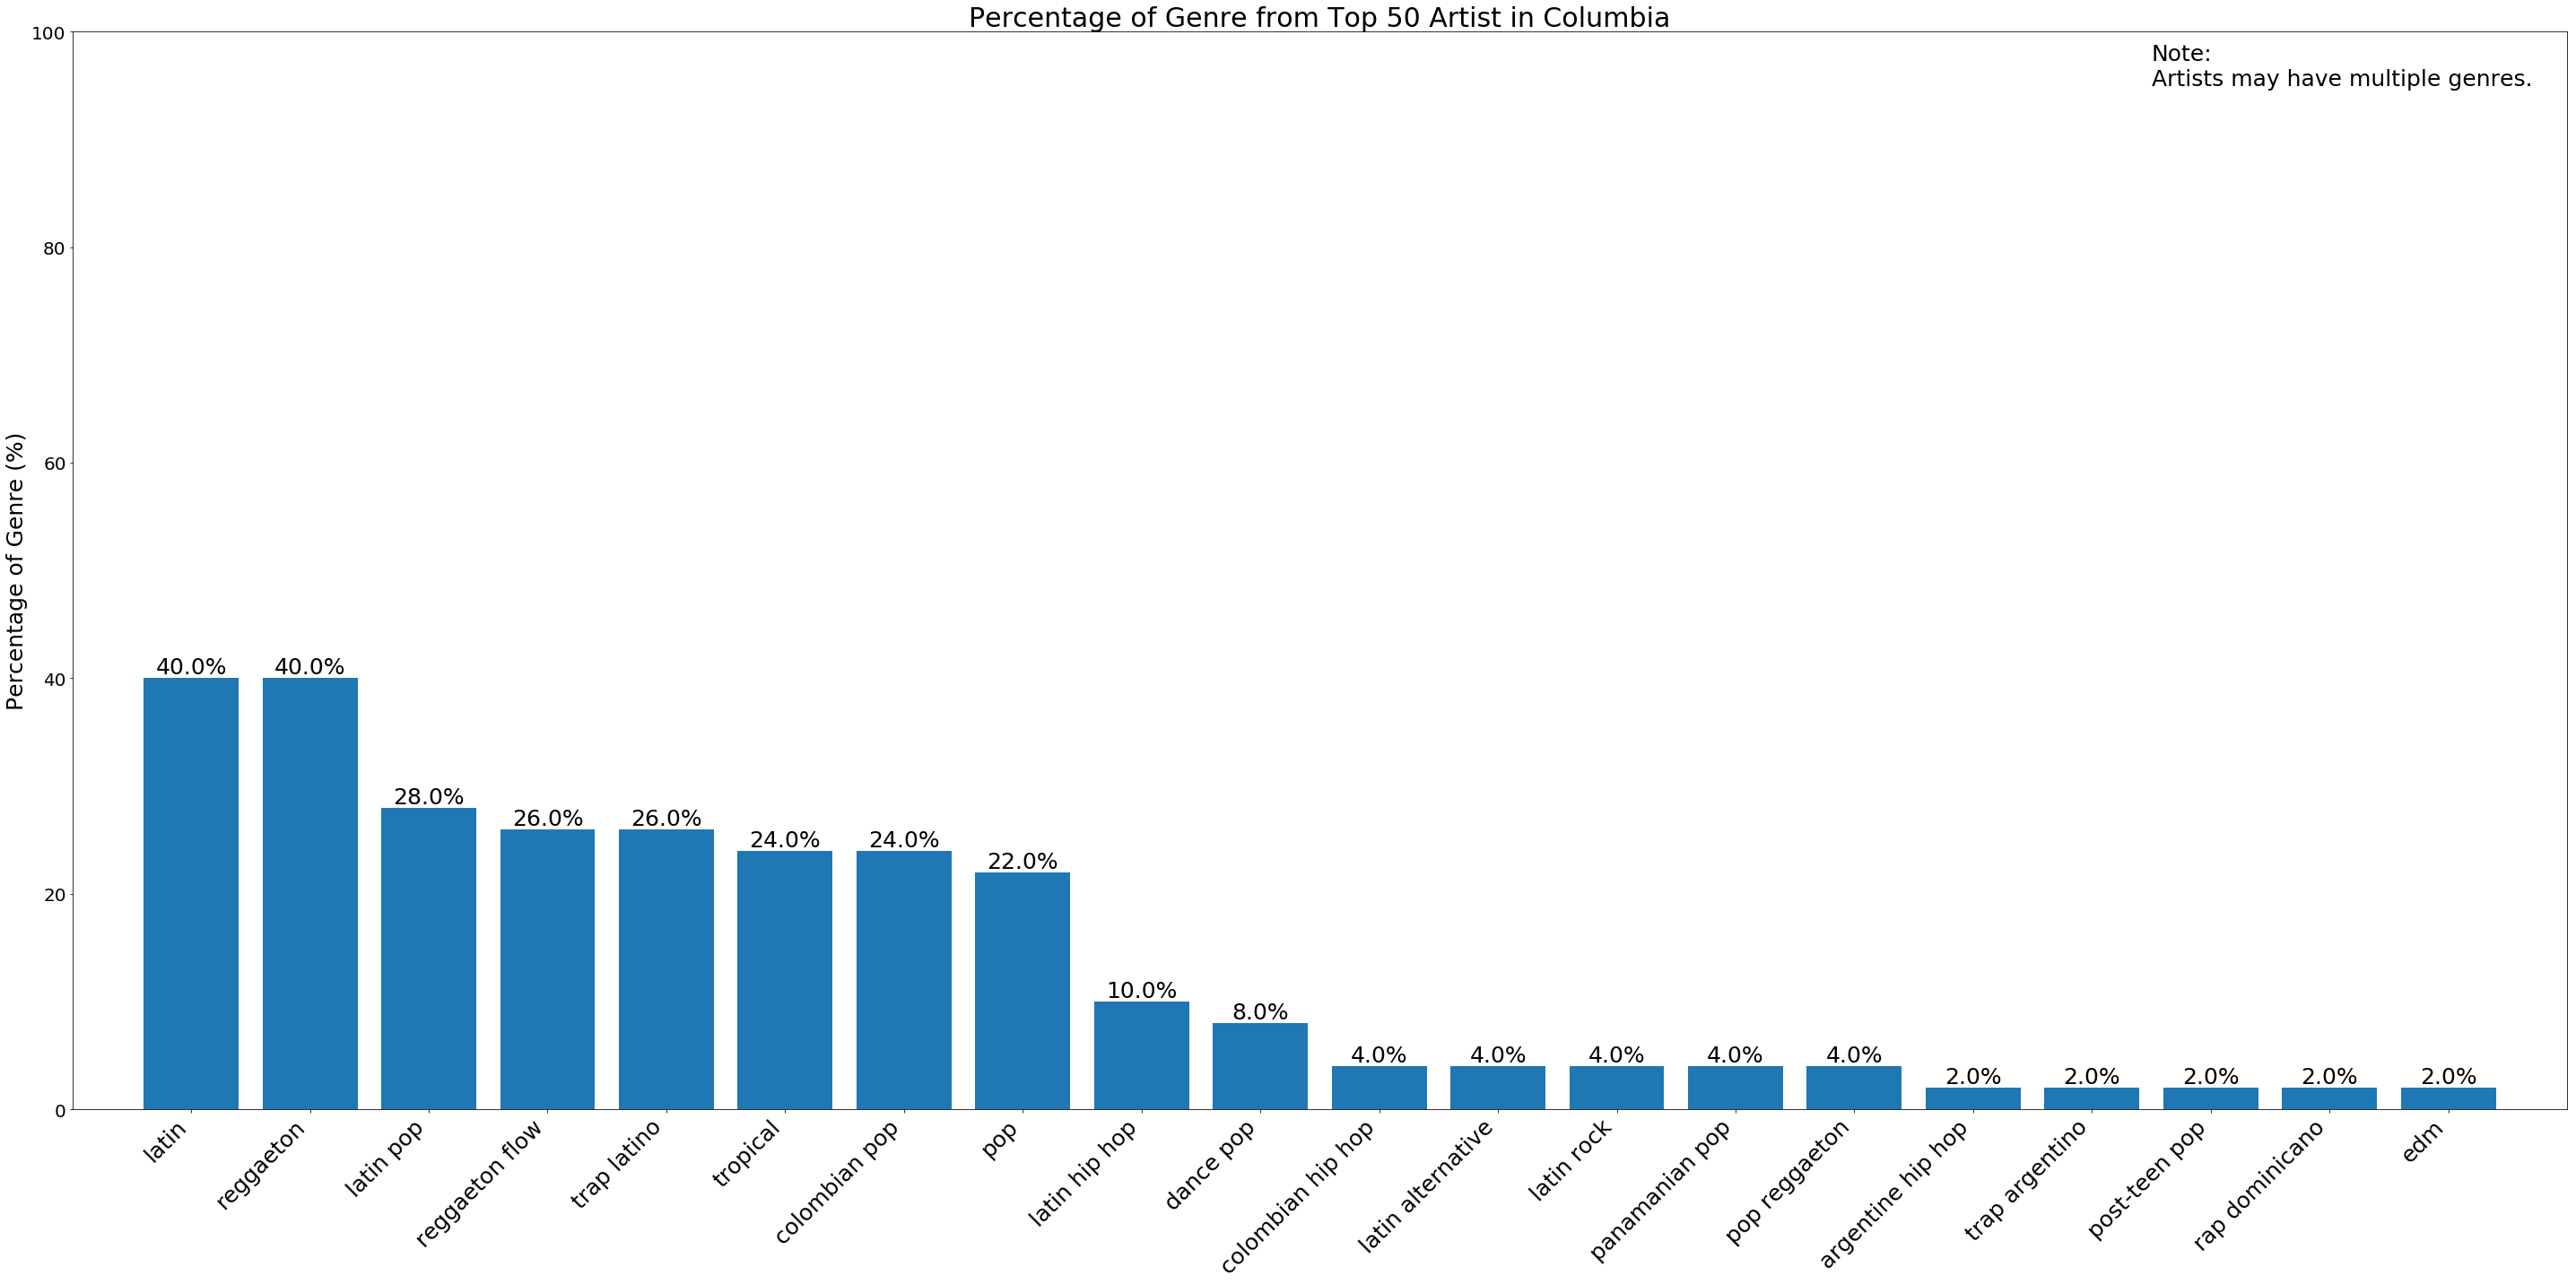

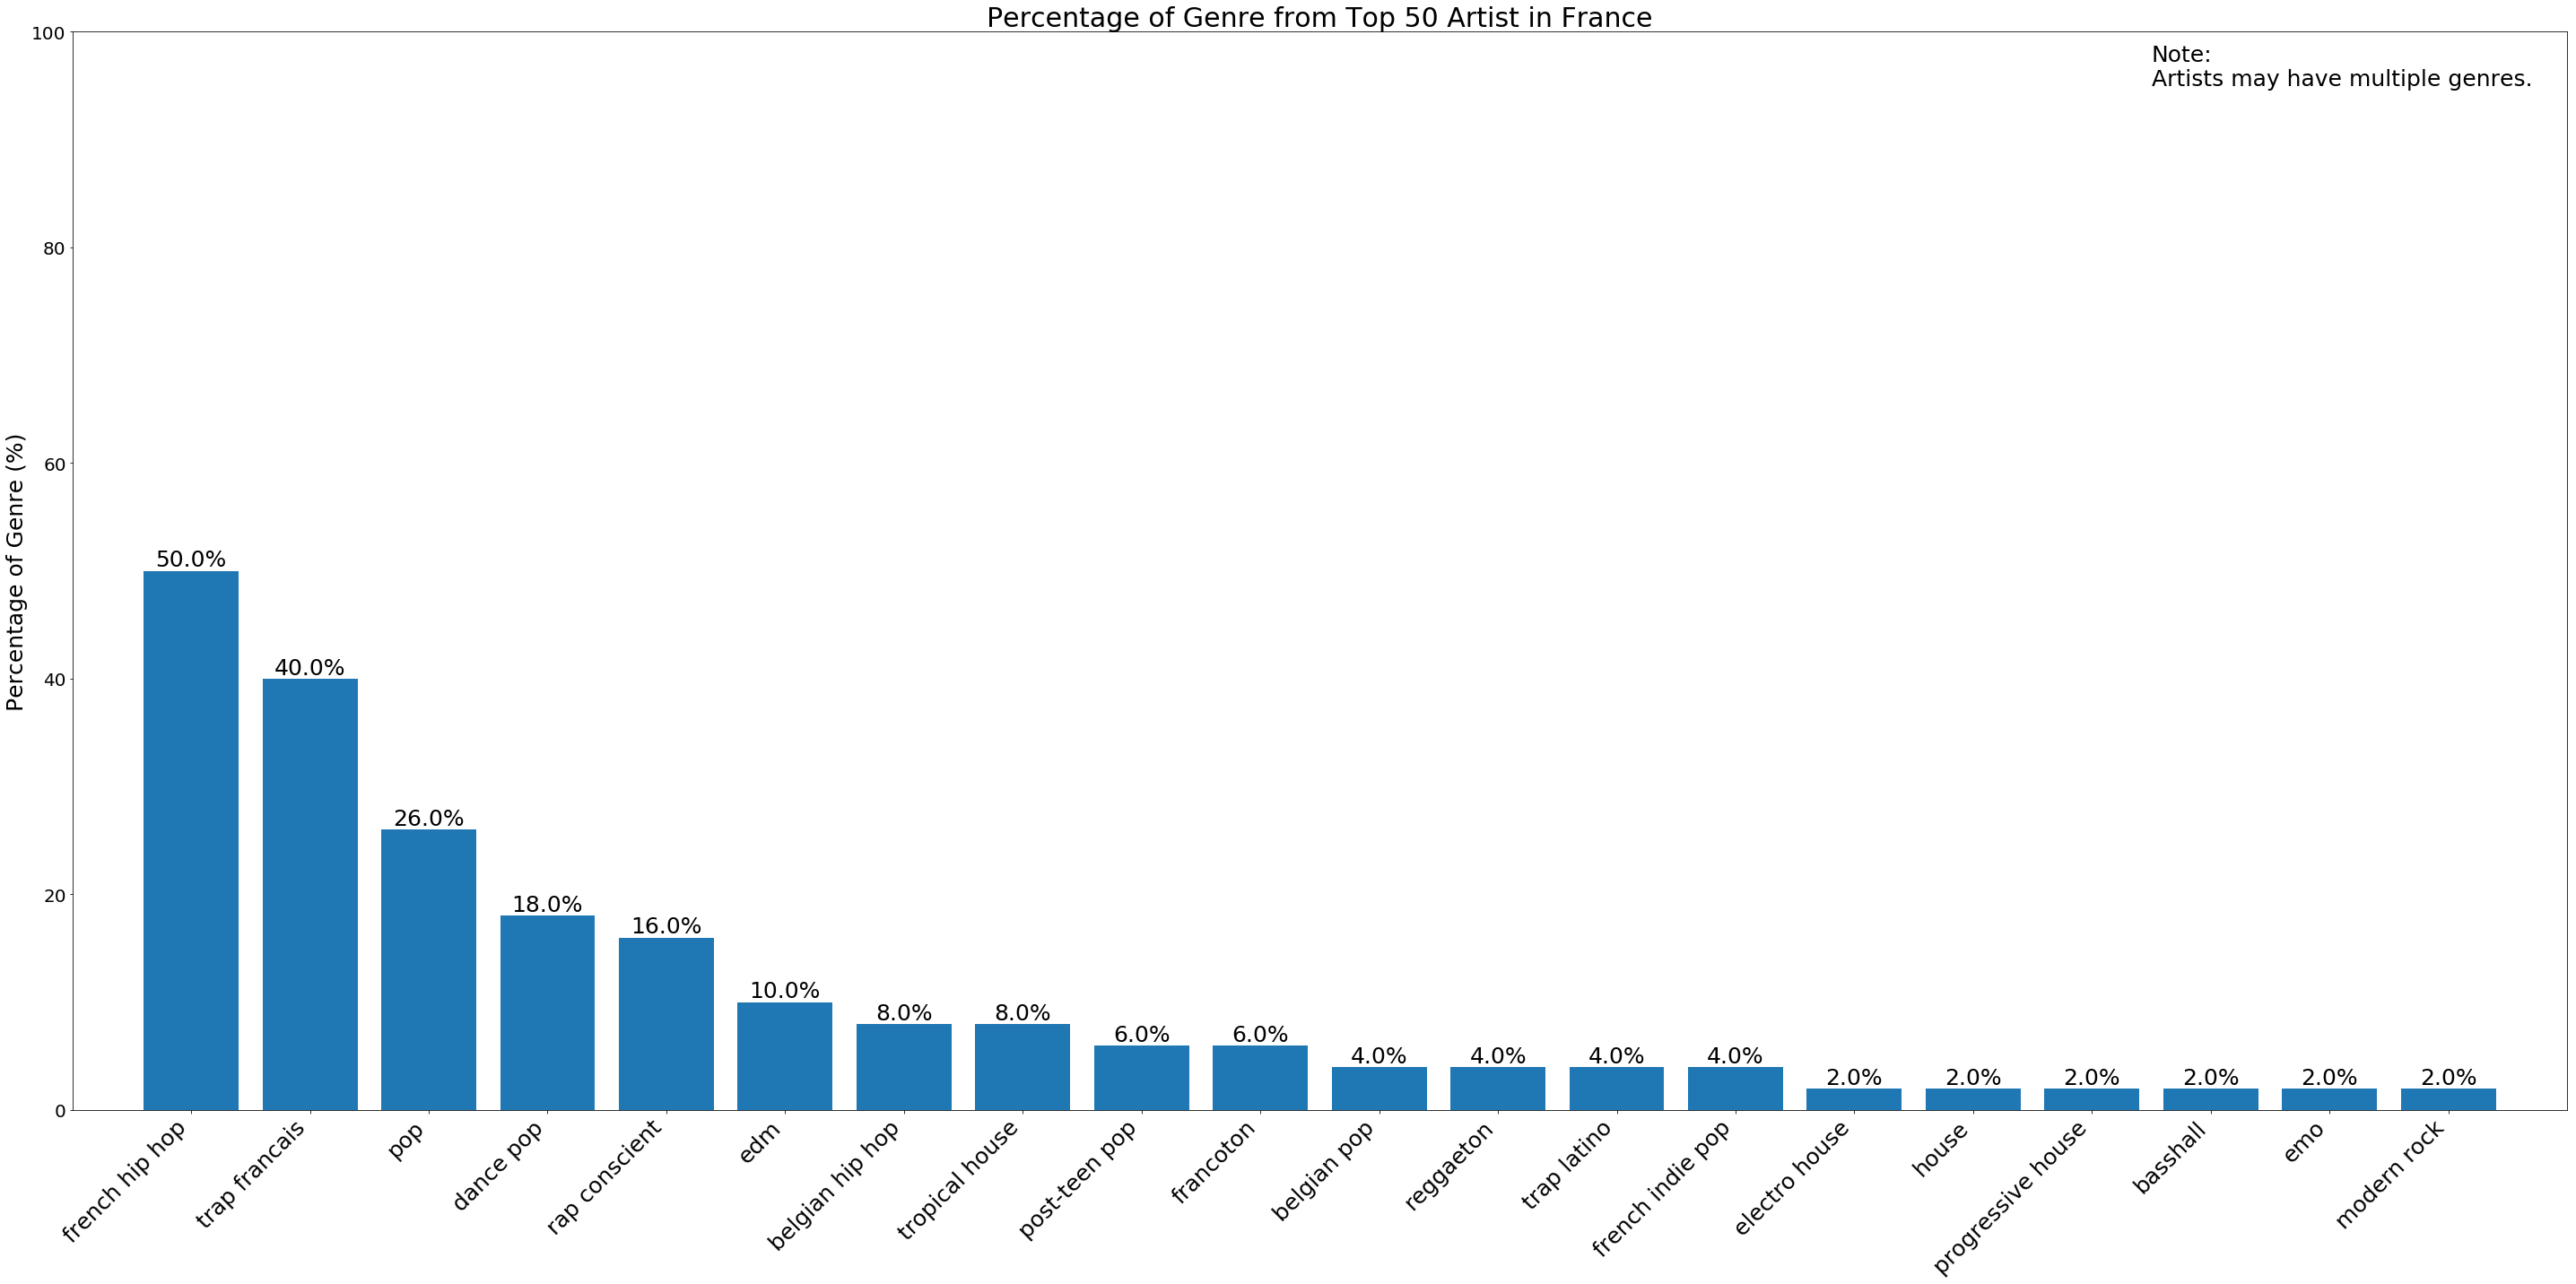

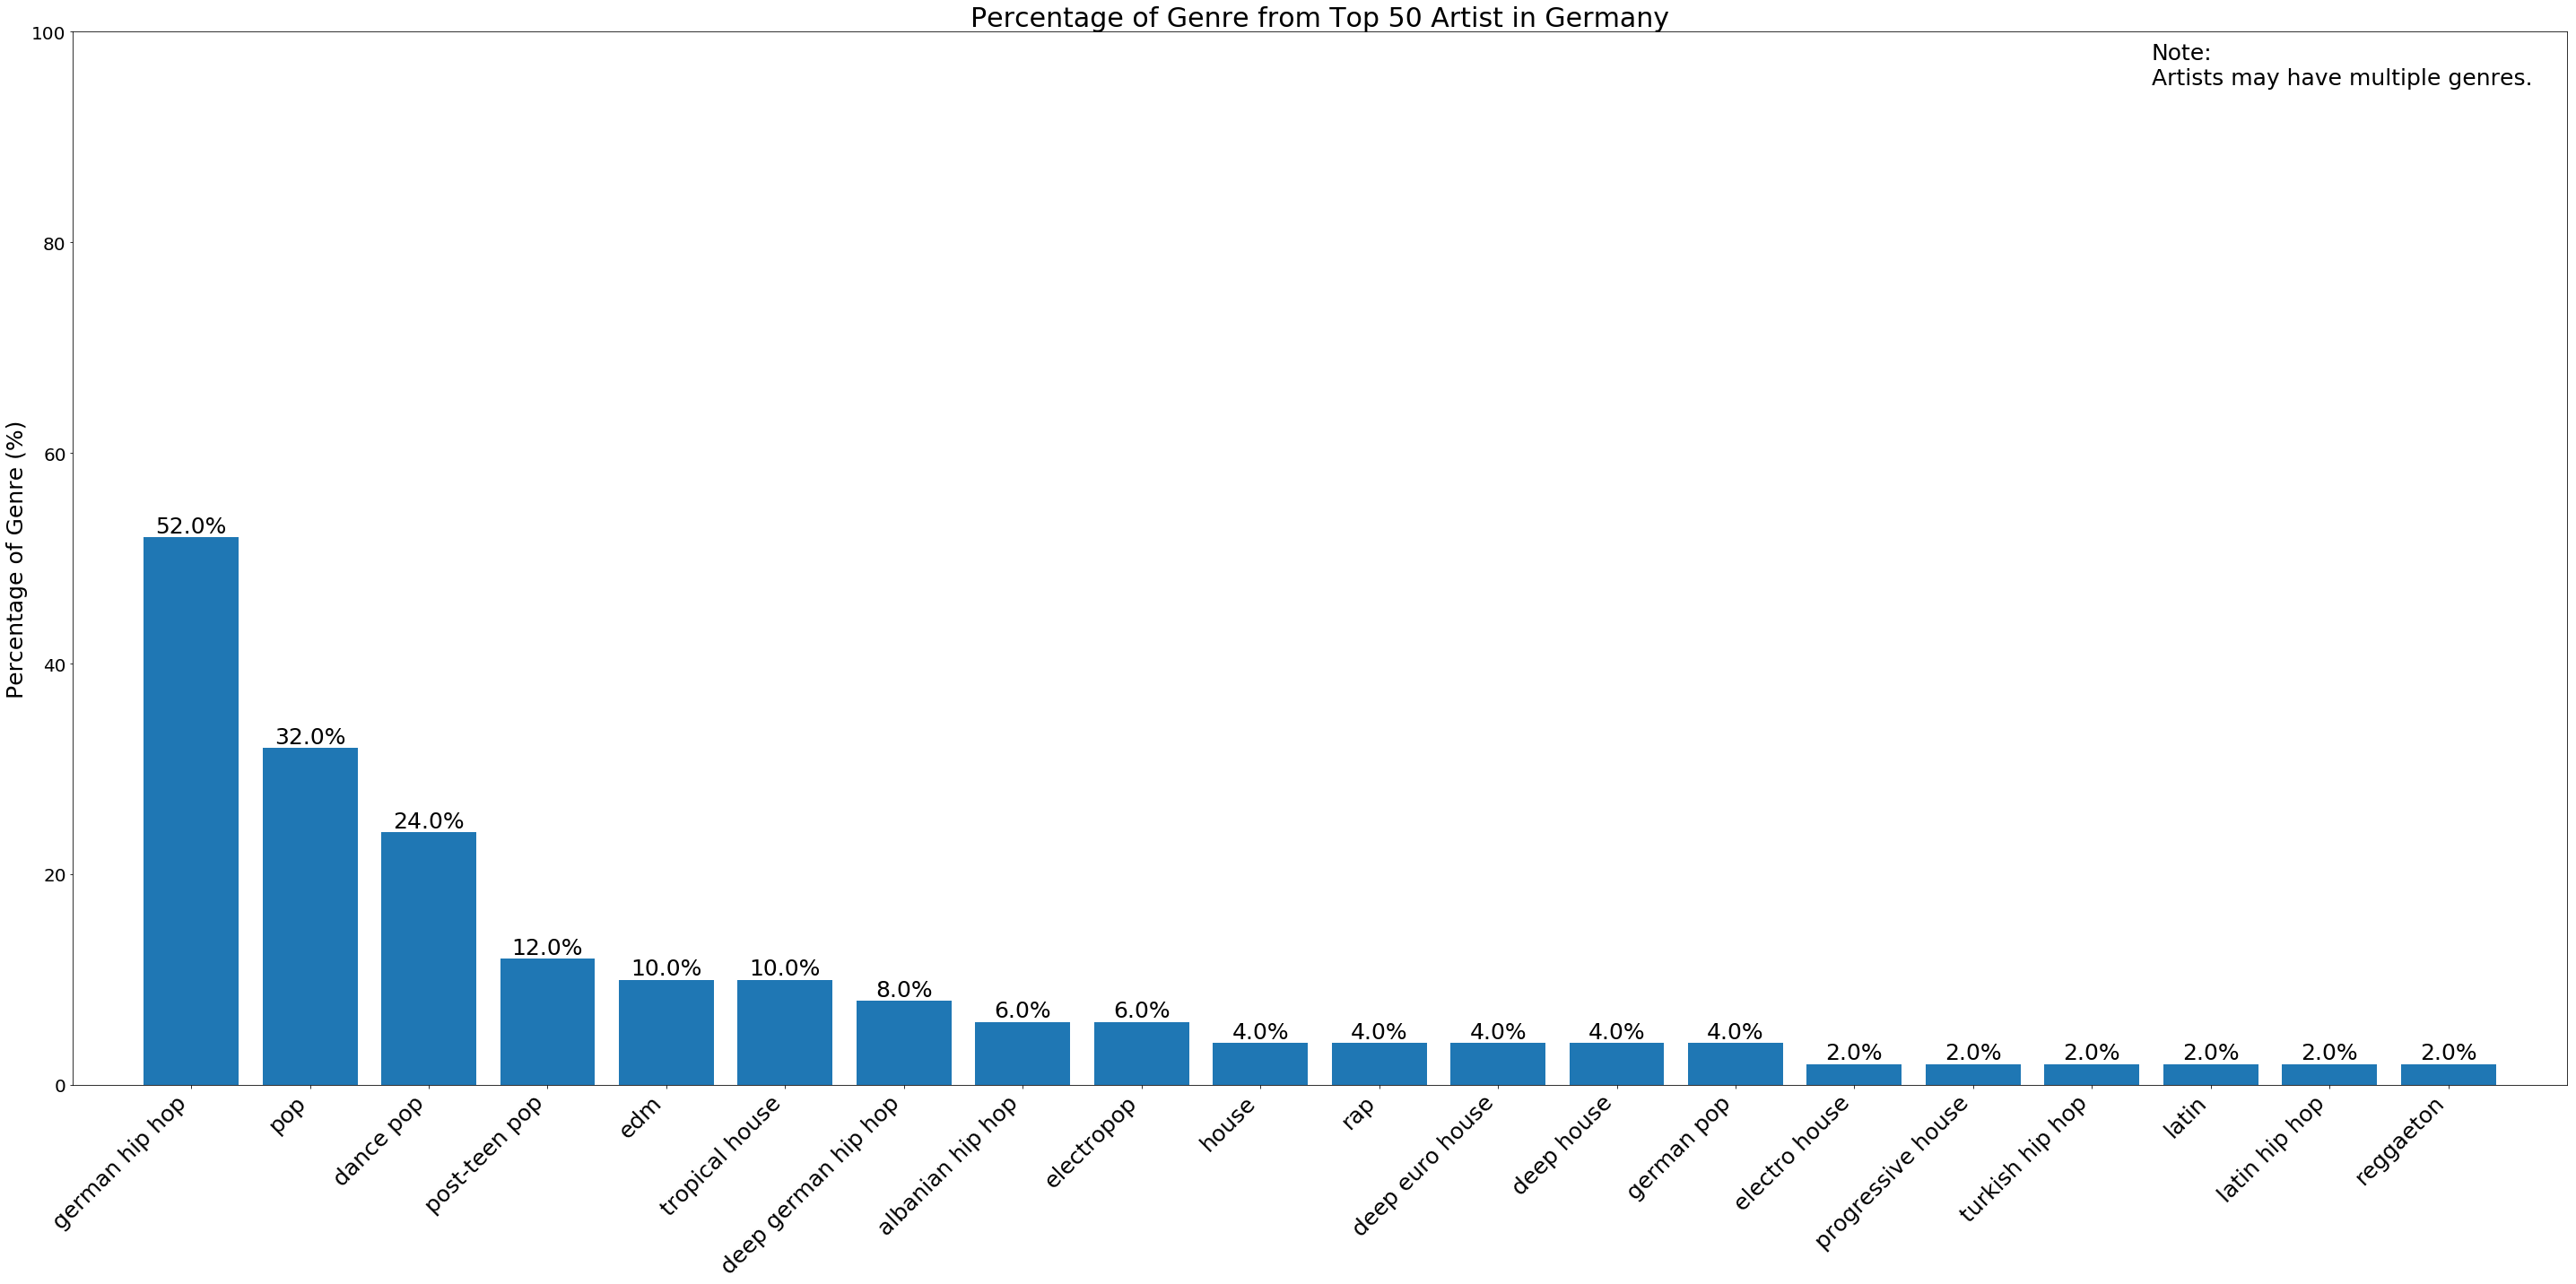

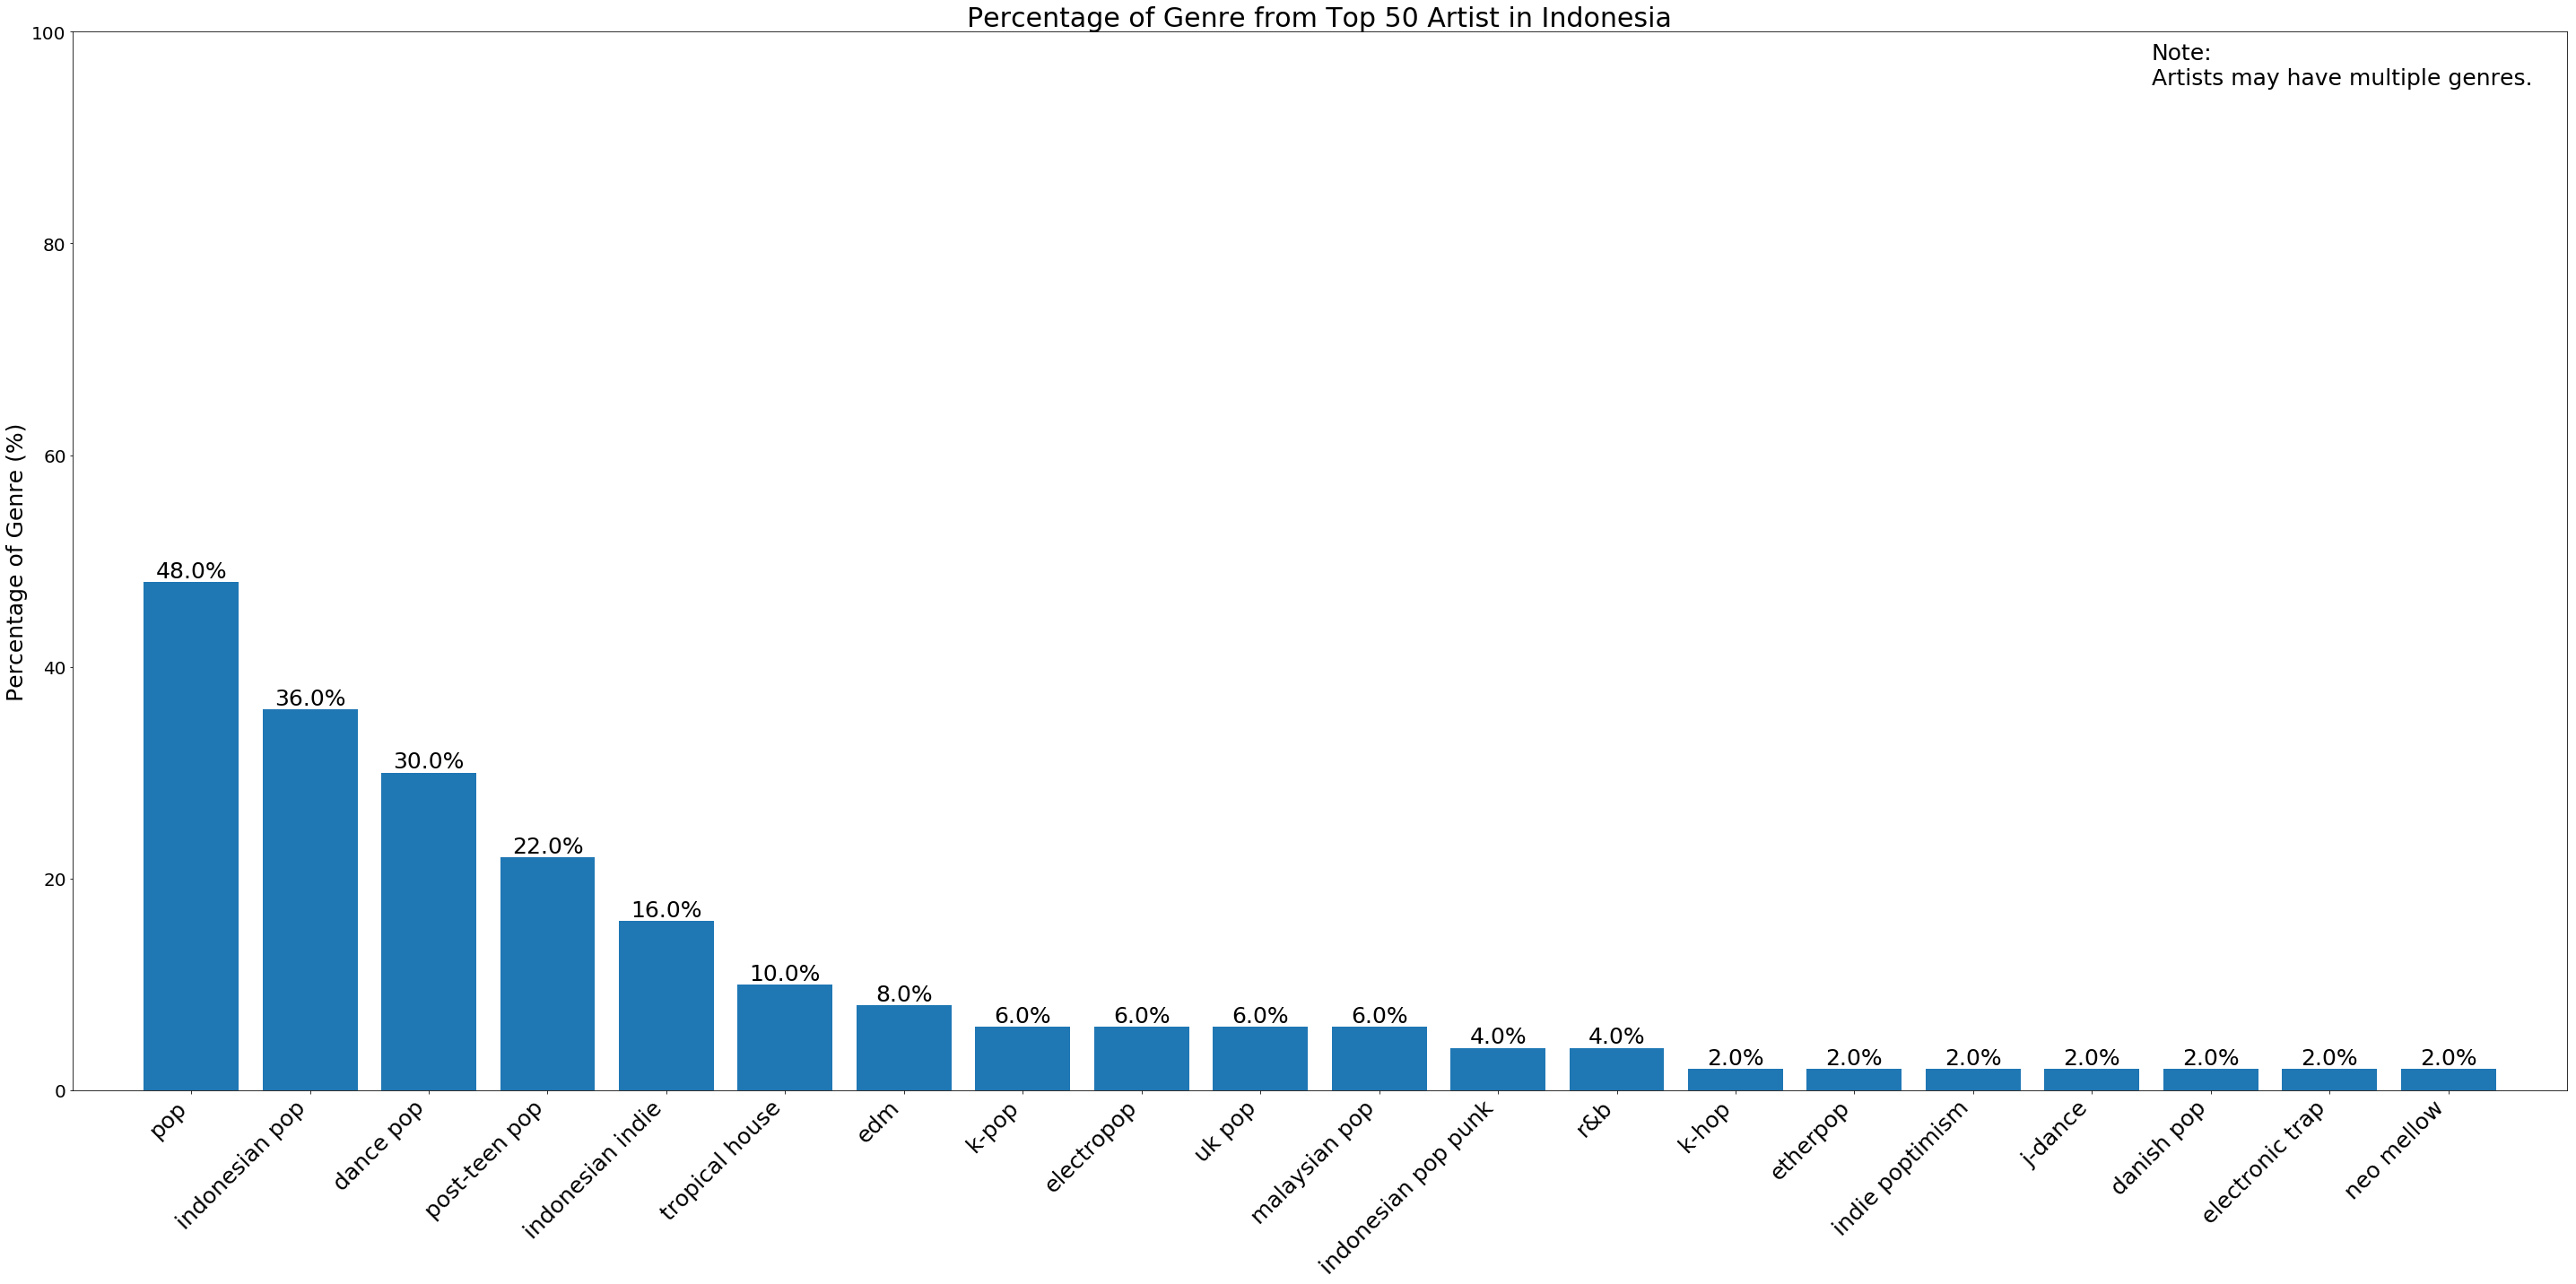

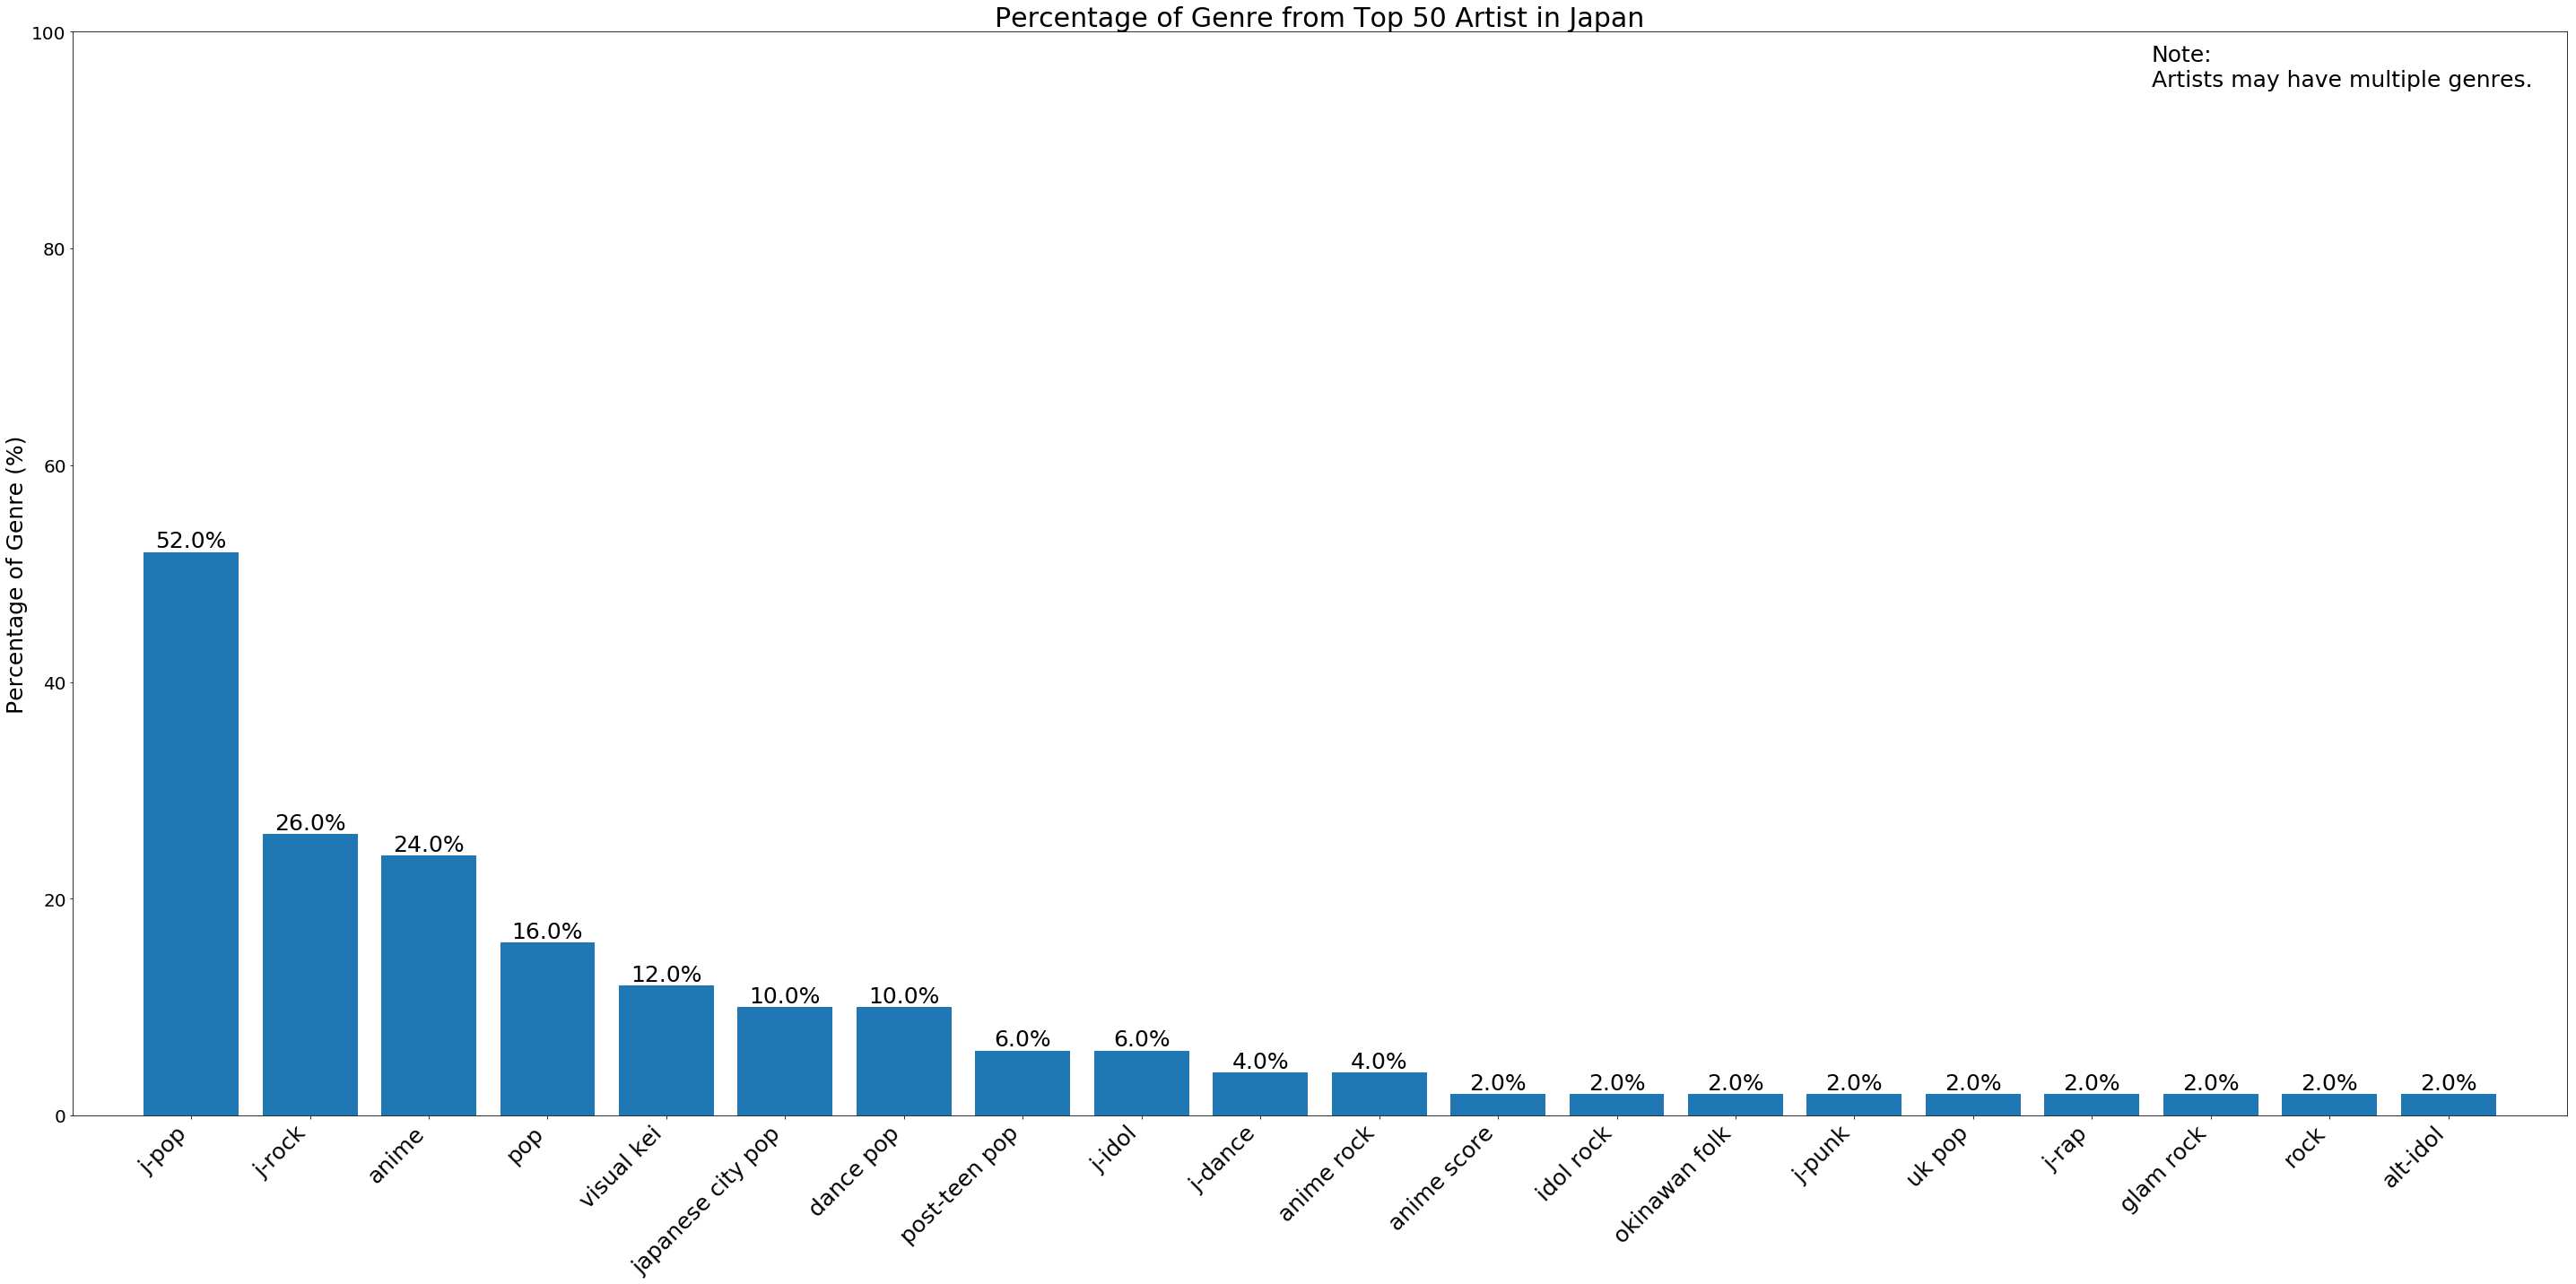

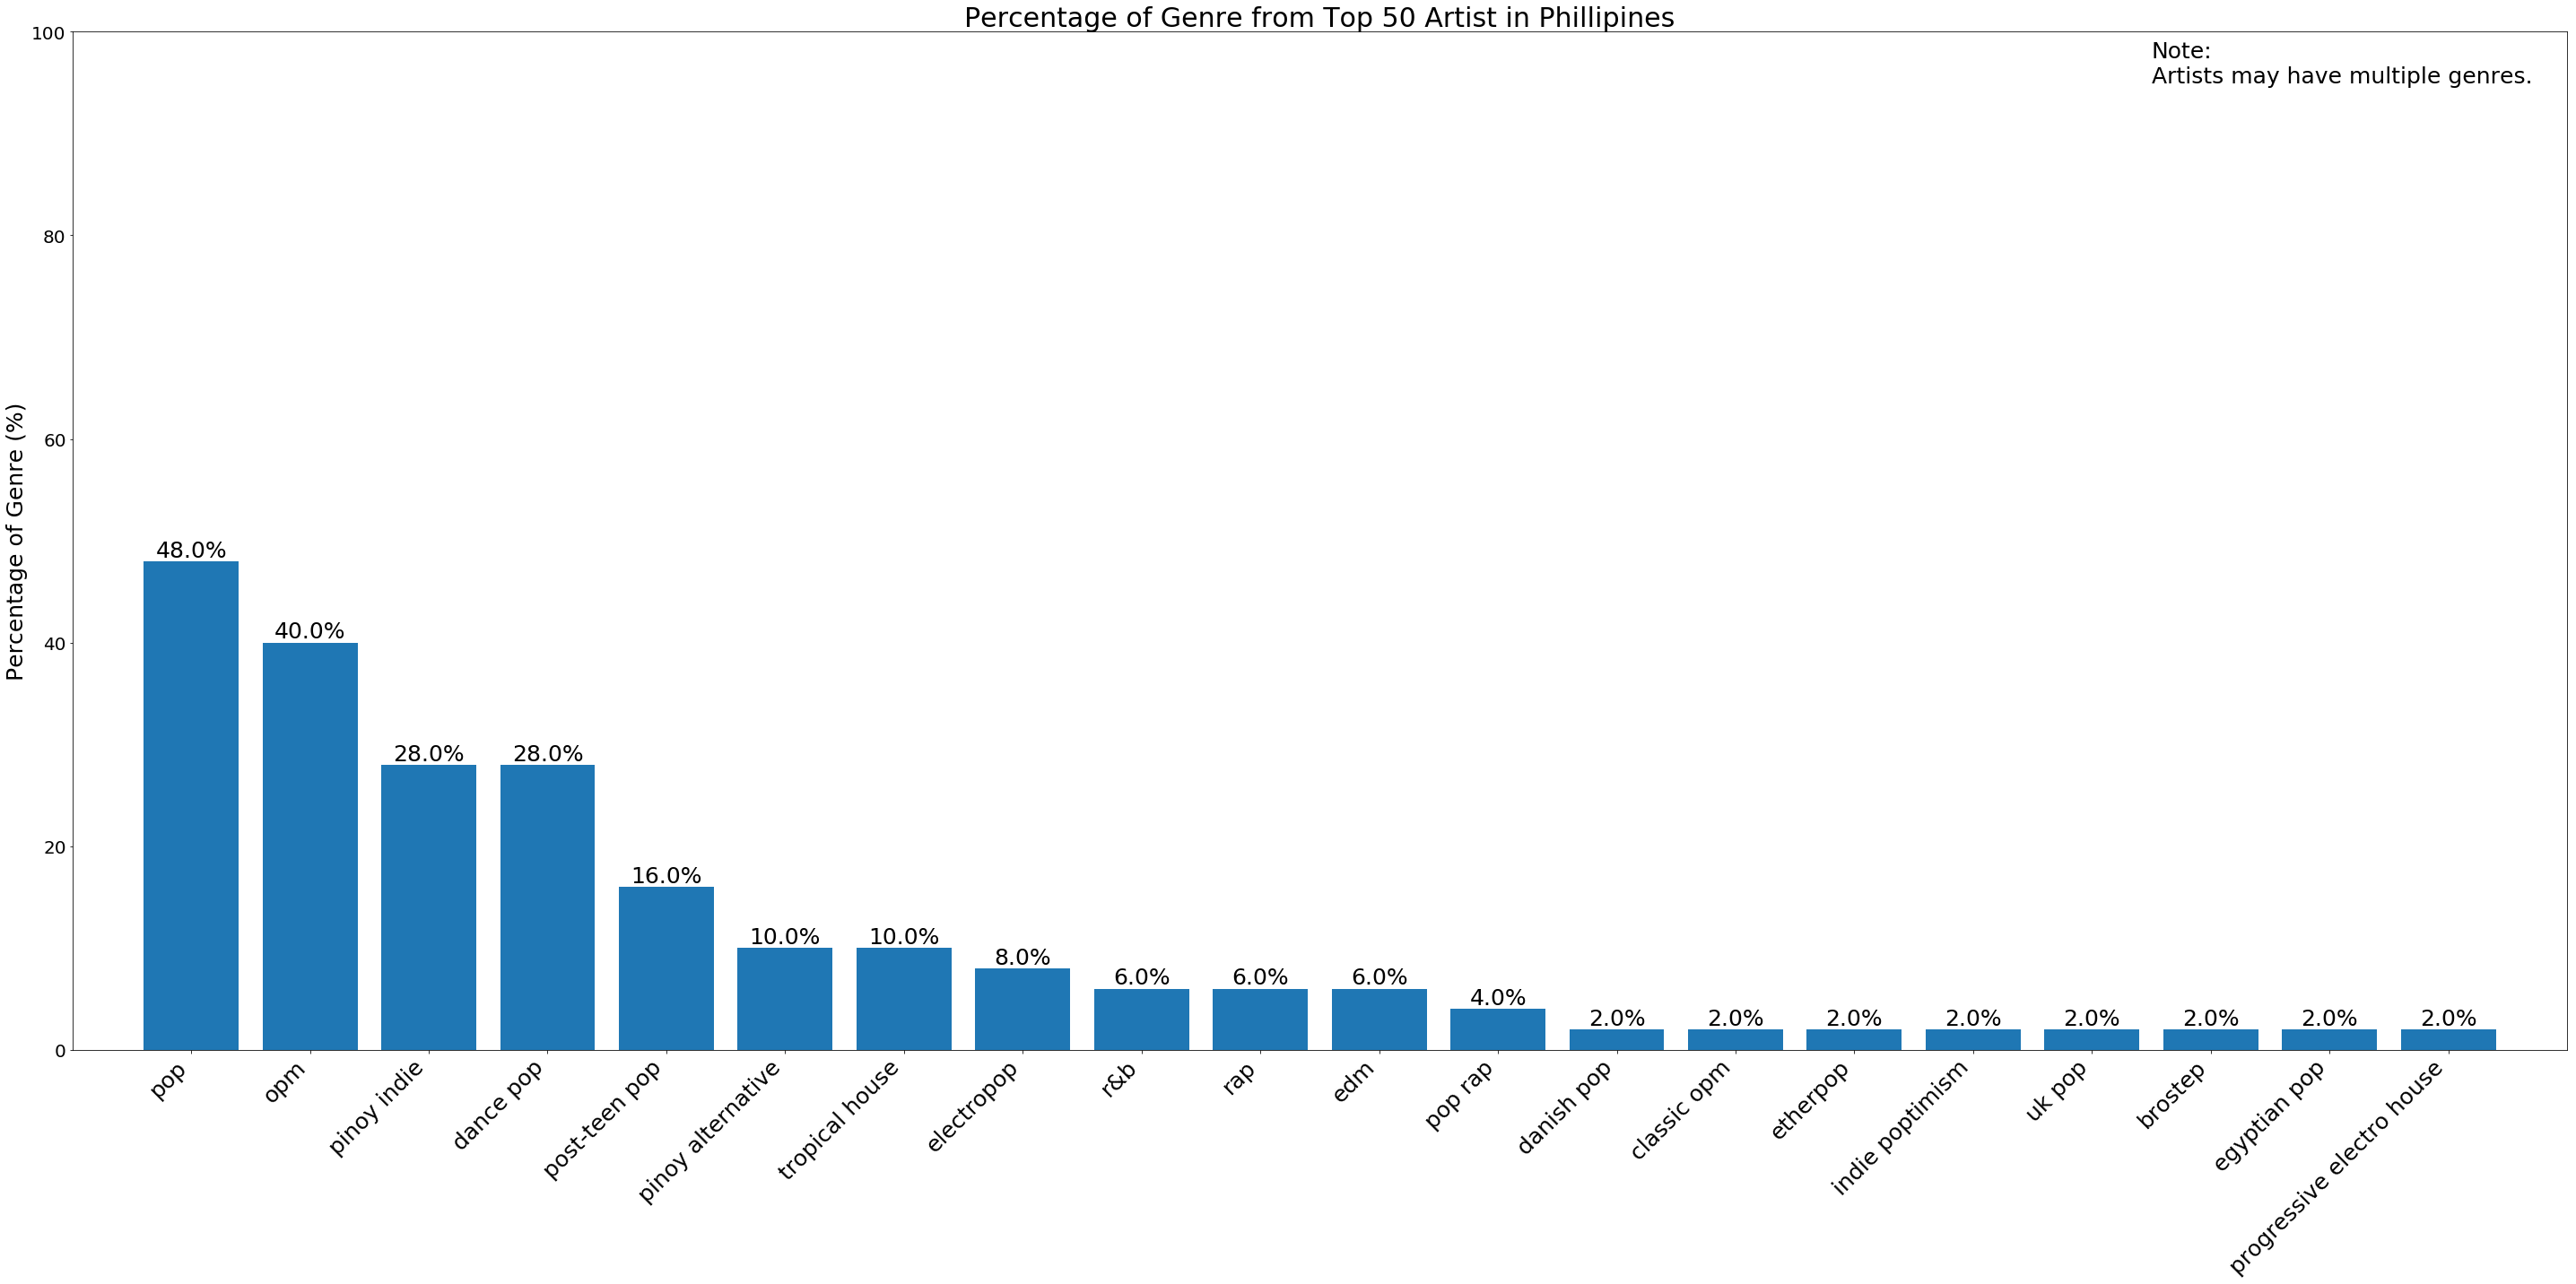

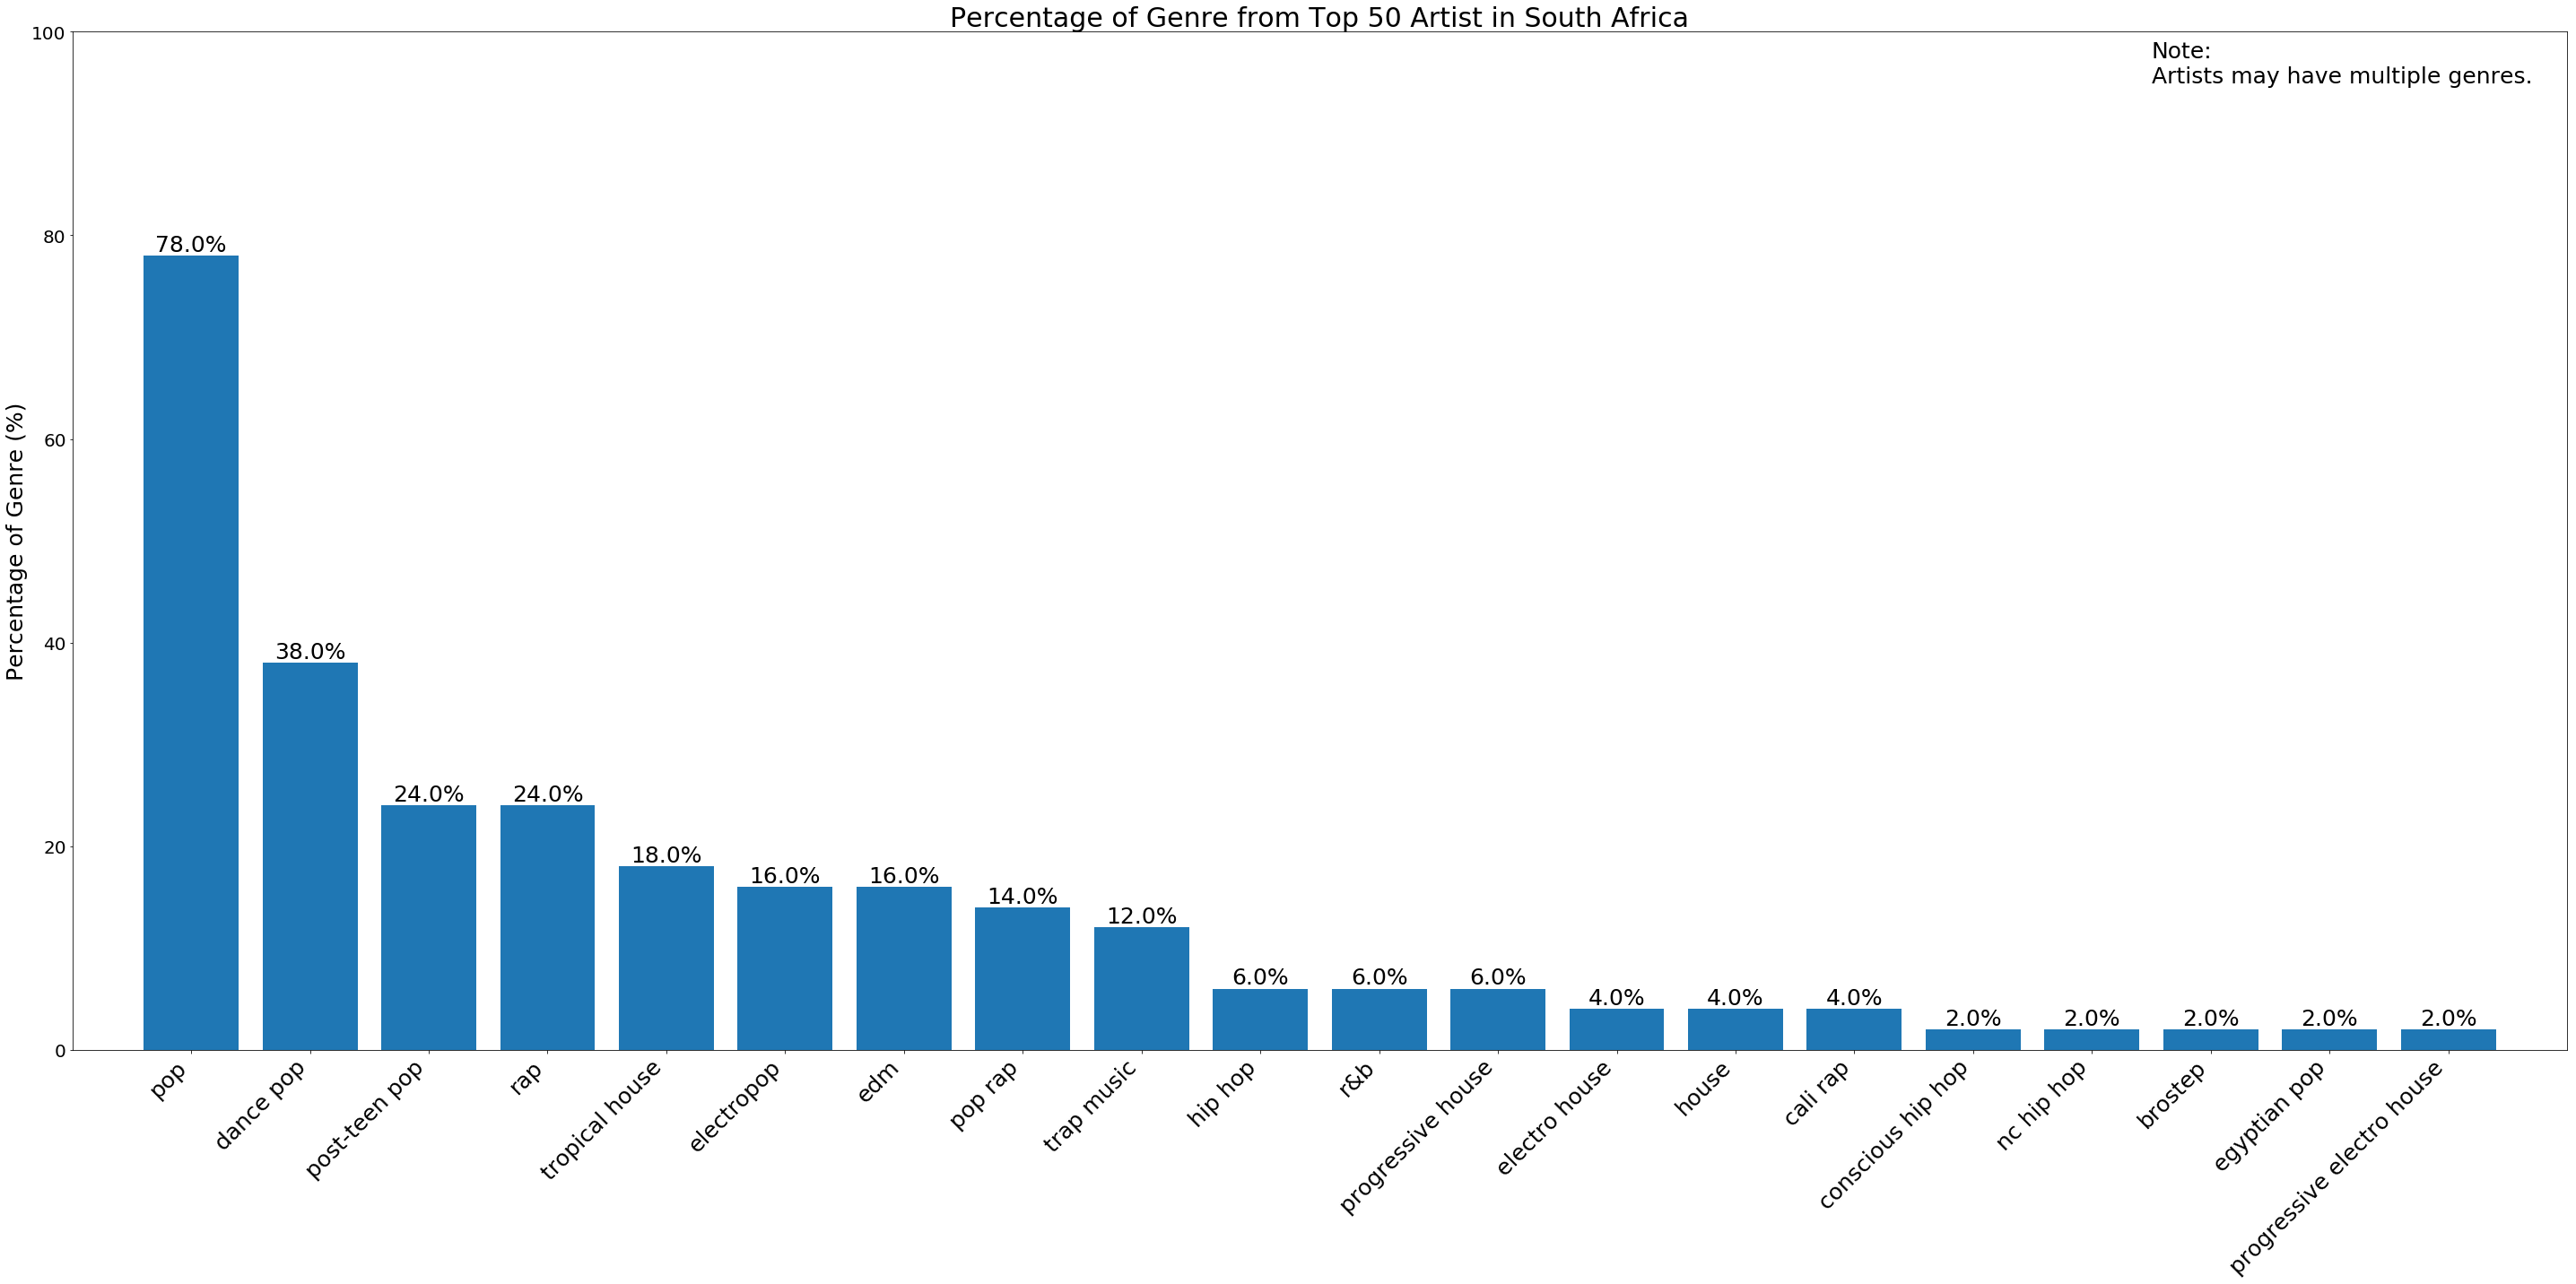

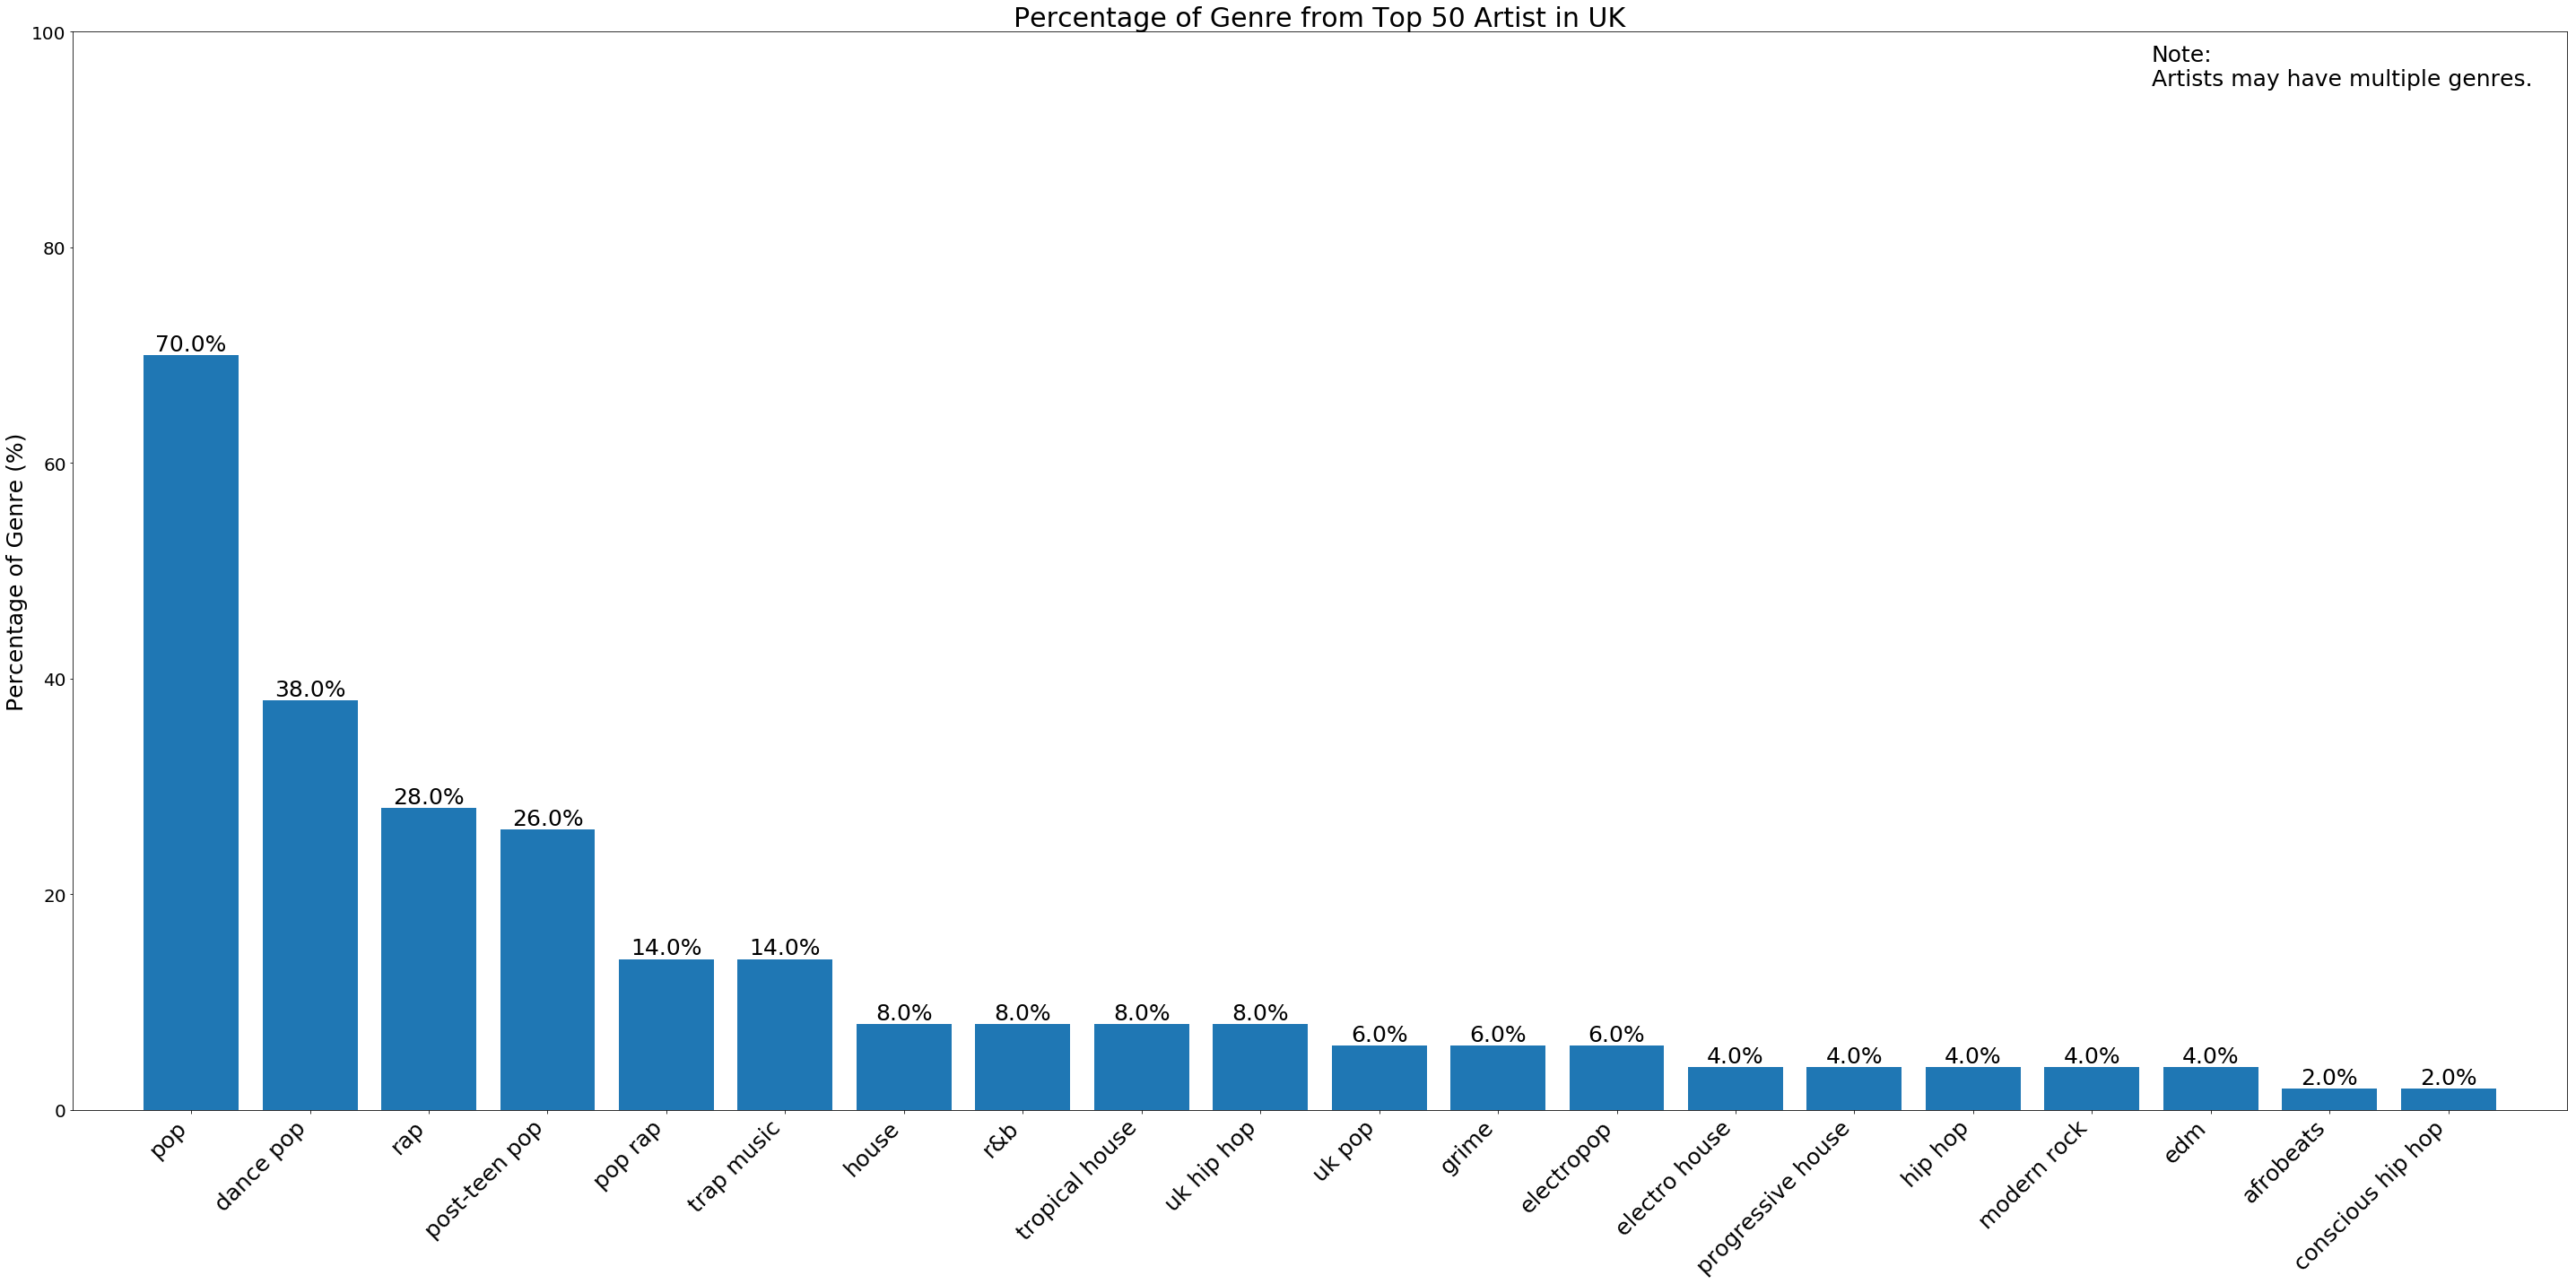

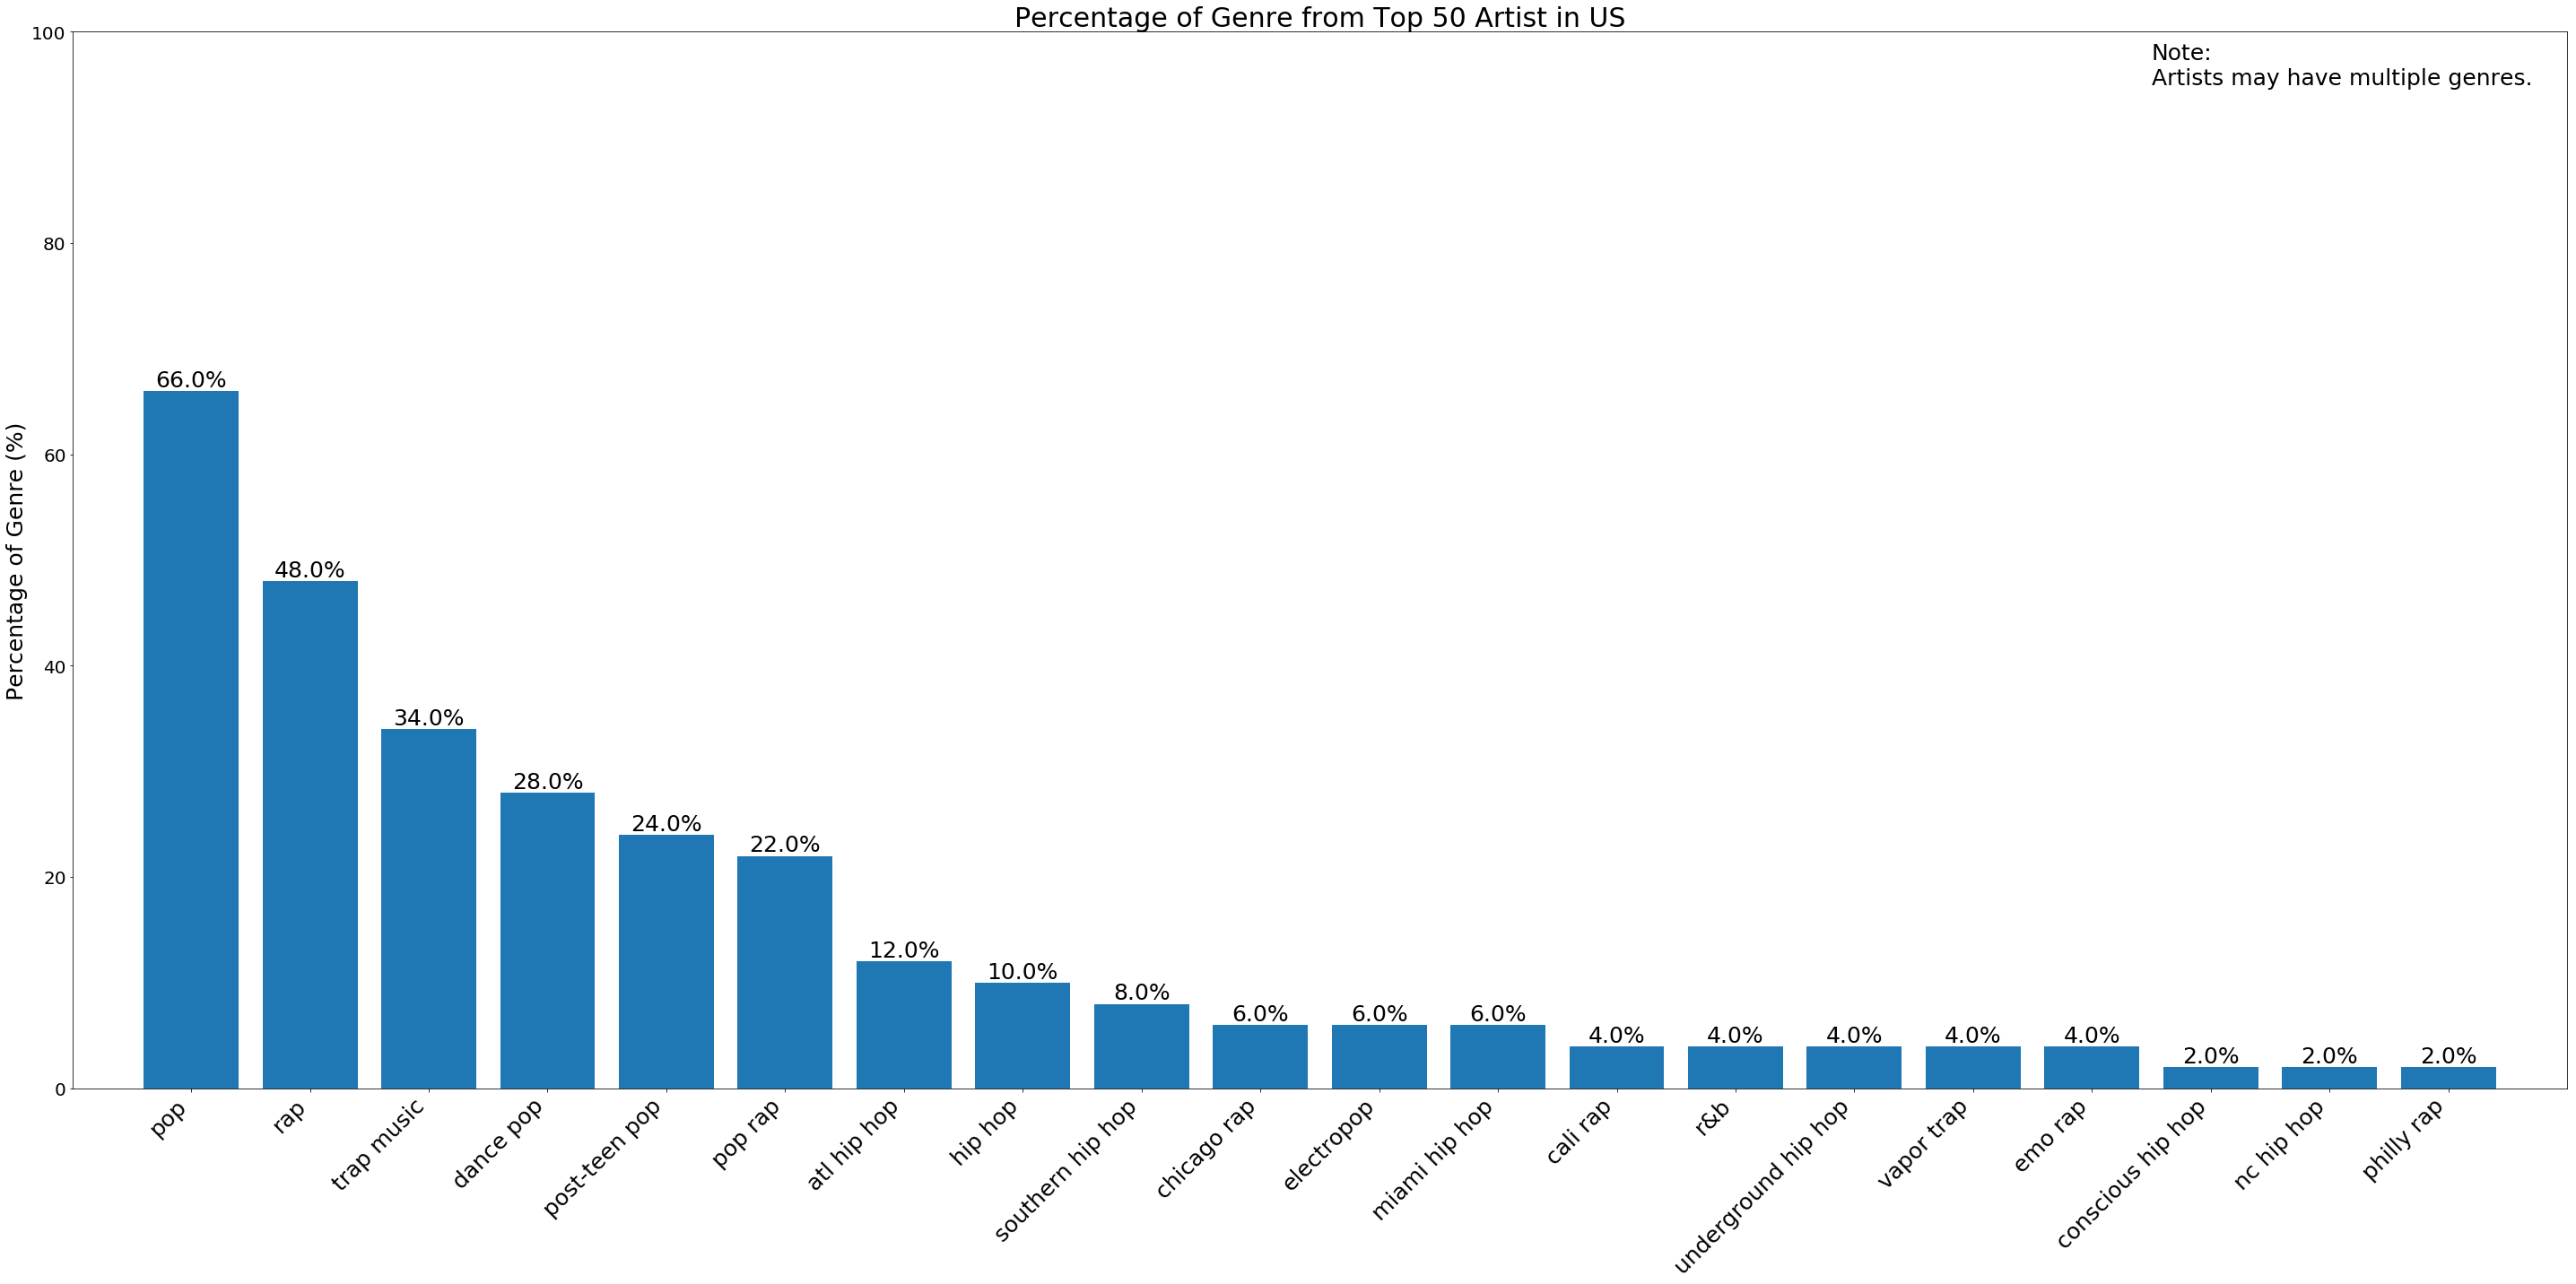

In [4]:
token_headers = {'authorization': f"Bearer {token}"}

for country_name in country:
    top50_df = pd.read_csv(f"Top Country CSV/{country_name}_top_50.csv")

    artist_count = 0
    genres = []
    genre_count = []

    search_artist_url = "https://api.spotify.com/v1/artists/"

    for artist_id in top50_df["Artist ID"]:
        artist_url = search_artist_url + artist_id

        artist_json = requests.get(artist_url, headers = token_headers).json()

        try:
            genres_list = artist_json["genres"]

            for genre in genres_list:
                if genre not in genres:
                    genres.append(genre)
                    genre_count.append(1)

                else:
                    genre_count[genres.index(genre)] += 1

            artist_count += 1

        except (KeyError, IndexError):
            print(f"Artist ID not found | {artist_id}")

    genre_zip = zip(genres, genre_count)
    sorted_genre_zip = sorted(genre_zip, key = lambda count : count[1], reverse = True)

    genre = list(zip(*sorted_genre_zip))[0]
    genre_count = list(zip(*sorted_genre_zip))[1]
    
    genre_popularity_df = pd.DataFrame({"Genres" : genre, "Genre Counts" : genre_count})
    genre_popularity_df["Genre Popularity Percentage"] = (genre_popularity_df["Genre Counts"]/artist_count) * 100
    genre_popularity_df.head()
    
    # Create Bar Graph Figure
    fig, ax = plt.subplots(figsize = (40,20))
    
    # Number of genres
    x_axis = np.arange(len(genre))[:20]

    # Percentage of genres
    y_axis = genre_popularity_df["Genre Popularity Percentage"][:20]

    # Create bar graph showing percentage of genres in US
    ax.bar(x_axis, y_axis)

    # Label x axis with genres
    plt.xticks(x_axis, genre_popularity_df["Genres"], Fontsize = 25, rotation = 45, ha = "right")
    plt.yticks(Fontsize = 20)

    plt.xlim(min(x_axis) - 1, max(x_axis) + 1)
    plt.ylim(0, 100)

    y_max = ax.get_ylim()[1]
    plt.ylabel("Percentage of Genre (%)", Fontsize = 25)
    plt.title(f"Percentage of Genre from Top 50 Artist in {country_name}", Fontsize = 30)
    plt.text(max(x_axis) - 2.5, 0.95 * y_max, "Note:\nArtists may have multiple genres.", Fontsize = 25)

    # Dimension of each box
    rects = ax.patches

    # Loops through each box to rab dimensions
    for rect in rects:

        # Width of Box
        box_width = rect.get_width()

        # Height of Box
        height = rect.get_height()

        # Center of Box
        center = rect.get_x() + box_width / 2

        # Text is above boxes if height greater than 0
        if height > 0:
            ax.text(center, height, f'{round(height,2)}%', Fontsize = 25, ha = 'center', va = 'bottom')

        # Text is below boxes if height is less than 0
        else:
             ax.text(center, height, f'{round(height,2)}%', Fontsize = 25, ha = 'center', va = 'top')

    plt.tight_layout()

    plt.savefig(f"Images/Percentage_of_Genre_from_Top50_Artists_in_{country_name}.png")

    plt.show()